# Analyze results of experiments

## Read data

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
theme_set(theme_light())
options(repr.plot.width=12, repr.plot.height=8, repr.plot.res=200)

In [3]:
multi <- read_csv("../logs/combined_multi.csv")

Parsed with column specification:
cols(
  run = col_character(),
  epoch = col_double(),
  train_loss = col_double(),
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double(),
  time = col_time(format = "")
)



In [4]:
multi <- multi %>%
    separate(run, c("in","focus","cv"), "_", remove=FALSE) %>%
    separate(focus, c("focus","weight"), "\\.", fill = "right") %>%
    mutate(cv = str_remove(cv, "cv"), run = str_remove(run, "_cv."))

In [5]:
head(multi)

run            in    focus    weight cv epoch train_loss valid_loss
1 multi_balanced multi balanced NA     0  1     0.08891164 0.05743562
2 multi_balanced multi balanced NA     0  2     0.06454016 0.03575942
3 multi_balanced multi balanced NA     0  3     0.04969874 0.02374812
4 multi_balanced multi balanced NA     0  4     0.03960447 0.01741276
5 multi_balanced multi balanced NA     0  5     0.03214885 0.01496669
6 multi_balanced multi balanced NA     0  6     0.02790543 0.01620819
  foreground_acc diceLV    diceMY      diceRV    diceEd    diceSc     time    
1 2.965599e-06   0.0000000 0.000000000 0.1200100 0.2000000 0.01333333 00:15:00
2 3.100325e-01   0.4178041 0.006557636 0.4087493 0.2000000 0.12000000 00:15:00
3 4.577135e-01   0.6874704 0.127052635 0.5367035 0.2000000 0.05205806 00:15:00
4 6.077567e-01   0.7009529 0.542749524 0.5492571 0.1904494 0.07868145 00:15:00
5 6.180432e-01   0.7382029 0.606098175 0.5053186 0.1979496 0.28558758 00:15:00
6 6.843118e-01   0.7380987 0.612615943 0.6091326 0.2000620 0.13211416 00:15:00

In [6]:
t2 <- read_csv("../logs/combined_t2.csv")
lge <- read_csv("../logs/combined_lge.csv")

Parsed with column specification:
cols(
  run = col_character(),
  epoch = col_double(),
  train_loss = col_double(),
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceFG = col_double(),
  time = col_time(format = "")
)

Parsed with column specification:
cols(
  run = col_character(),
  epoch = col_double(),
  train_loss = col_double(),
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceFG = col_double(),
  time = col_time(format = "")
)



In [7]:
lge <- lge %>%
    separate(run, c("in","focus","cv"), "_", remove=FALSE) %>%
    separate(focus, c("focus","weight"), "\\.", fill = "right") %>%
    mutate(cv = str_remove(cv, "cv"), run = str_remove(run, "_cv.")) %>%
    rename(diceSc = diceFG)
t2 <- t2 %>%
    separate(run, c("in","focus","cv"), "_", remove=FALSE) %>%
    separate(focus, c("focus","weight"), "\\.", fill = "right") %>%
    mutate(cv = str_remove(cv, "cv"), run = str_remove(run, "_cv.")) %>%
    rename(diceEd = diceFG)

In [8]:
data <- bind_rows(multi,lge,t2)

## Exploration

### Look at loss and dices throughout training

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 278 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 278 rows containing missing values (geom_point).”


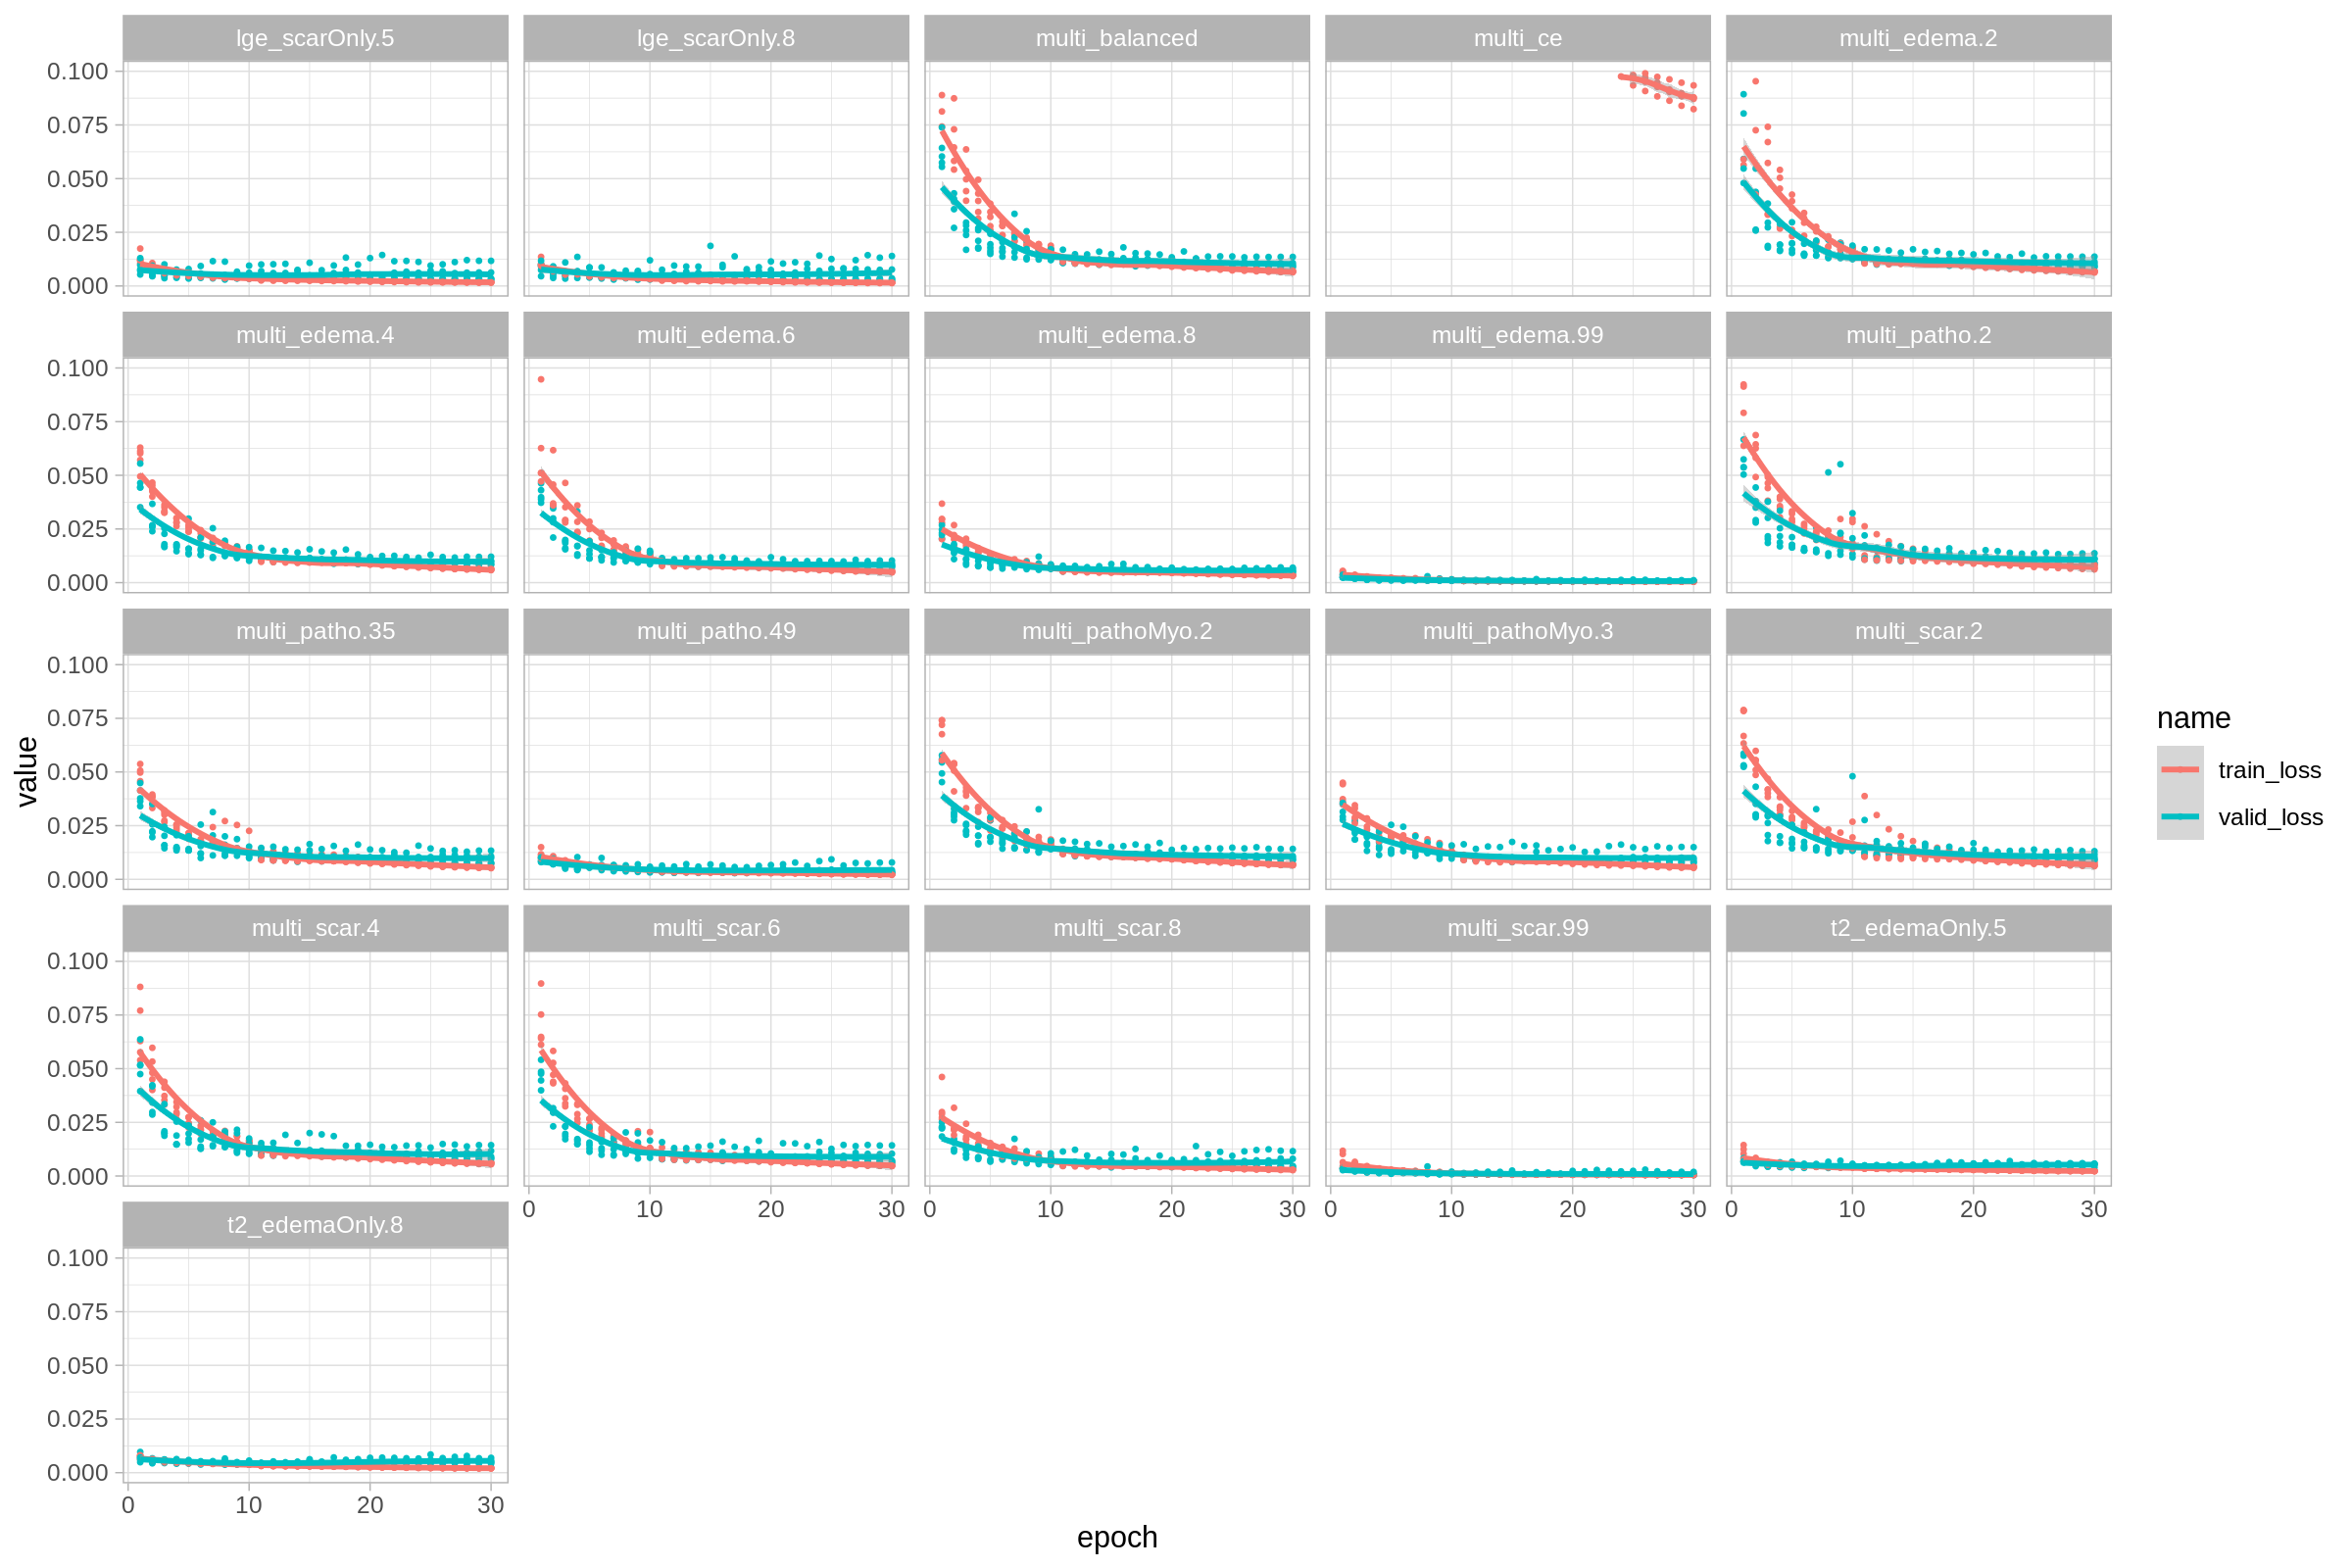

In [10]:
data %>%
    pivot_longer(contains("loss")) %>%
    #filter(focus != "ce", startsWith(run, "multi")) %>%
    ggplot(aes(epoch, value, color=name))+ #, shape=cv)) +
        geom_point(size=.5) +
        geom_smooth() +
        facet_wrap(.~run) +
        ylim(0,.1)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 2400 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2400 rows containing missing values (geom_point).”


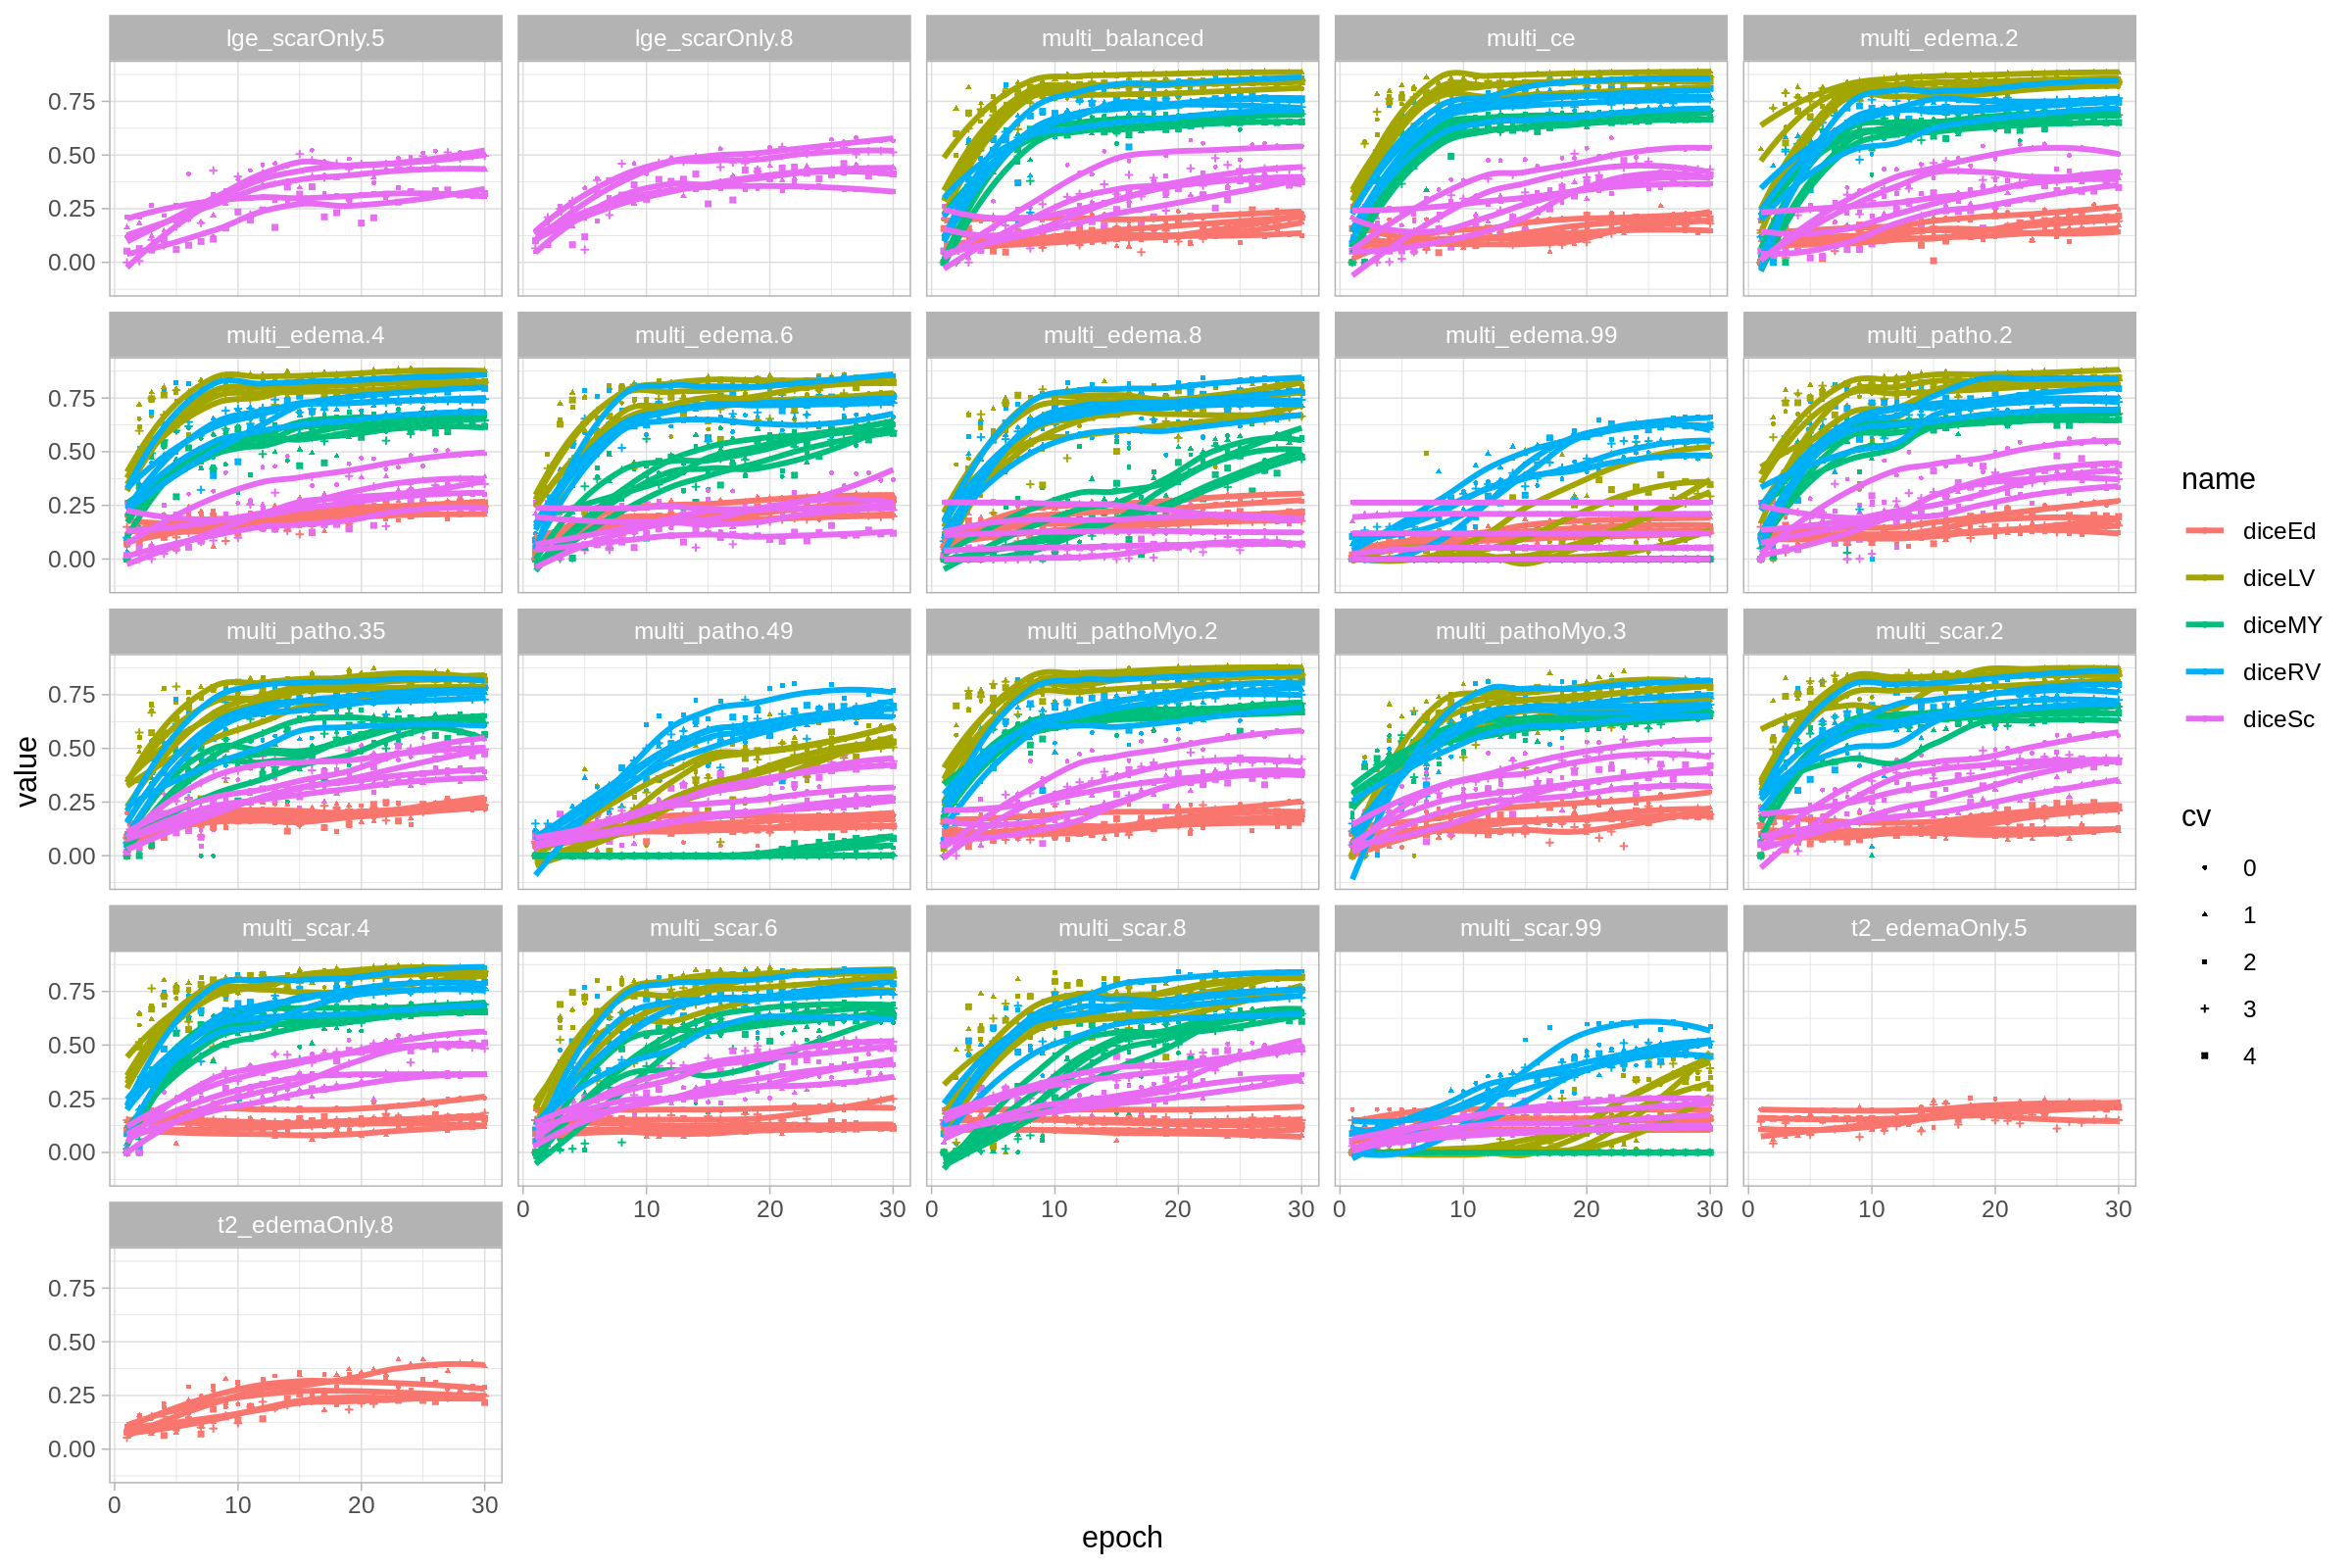

In [11]:
data %>%
    pivot_longer(contains("dice")) %>%
    #filter(focus != "ce", startsWith(run, "multi")) %>%
    ggplot(aes(epoch, value, color=name, shape=cv))+ #, shape=cv)) +
        geom_point(size=.5) +
        geom_smooth(se=FALSE) +
        facet_wrap(.~run)

### Final performance table

In [14]:
perf <- data %>% filter(epoch==30) %>% group_by(`in`,focus,weight) %>% summarise(across(starts_with("dice"), ~ mean(.x, na.rm = TRUE)))
perf

`summarise()` regrouping output by 'in', 'focus' (override with `.groups` argument)



in    focus     weight diceLV    diceMY     diceRV    diceEd    diceSc   
1  lge   scarOnly  5            NaN        NaN       NaN       NaN 0.4113498
2  lge   scarOnly  8            NaN        NaN       NaN       NaN 0.4529517
3  multi balanced  NA     0.8472374 0.68487955 0.7606308 0.1924807 0.4261342
4  multi ce        NA     0.8552887 0.69591962 0.7826109 0.1924488 0.4285691
5  multi edema     2      0.8476575 0.68188788 0.7658583 0.1935602 0.4146123
6  multi edema     4      0.8382191 0.65359944 0.7662371 0.2475796 0.3503787
7  multi edema     6      0.8069831 0.60649825 0.7465921 0.2433589 0.2501248
8  multi edema     8      0.7536457 0.50884939 0.7481146 0.2343428 0.1286620
9  multi edema     99     0.3217337 0.00000000 0.5824268 0.1465230 0.1292632
10 multi patho     2      0.8426679 0.67585491 0.7646106 0.1839383 0.4177773
11 multi patho     35     0.8090096 0.61940503 0.7380192 0.2369942 0.4537339
12 multi patho     49     0.5492239 0.03962845 0.6978247 0.1654627 0.3393397
13 multi pathoMyo  2      0.8462957 0.69152088 0.7742878 0.1987140 0.4373646
14 multi pathoMyo  3      0.7664072 0.65932462 0.7218119 0.2188349 0.4274810
15 multi scar      2      0.8465781 0.67608562 0.7711654 0.1814547 0.4454481
16 multi scar      4      0.8396950 0.67360096 0.7721655 0.1690721 0.4562239
17 multi scar      6      0.8192314 0.65220462 0.7467048 0.1618284 0.4321577
18 multi scar      8      0.7890620 0.64206444 0.7463965 0.1346176 0.4278879
19 multi scar      99     0.3295913 0.00000000 0.5105173 0.1436842 0.1761693
20 t2    edemaOnly 5            NaN        NaN       NaN 0.2099299       NaN
21 t2    edemaOnly 8            NaN        NaN       NaN 0.2781048       NaN

In [16]:
print("Edema")
perf %>% arrange(desc(diceEd)) %>% head(2)
perf %>% arrange(desc(diceSc)) %>% head(3)
perf %>% arrange(desc(diceLV)) %>% head(1)
perf %>% arrange(desc(diceRV)) %>% head(1)
perf %>% arrange(desc(diceMY)) %>% head(1)

[1] "Edema"


in    focus     weight diceLV    diceMY    diceRV    diceEd    diceSc   
1 t2    edemaOnly 8            NaN       NaN       NaN 0.2781048       NaN
2 multi edema     4      0.8382191 0.6535994 0.7662371 0.2475796 0.3503787

in    focus    weight diceLV    diceMY   diceRV    diceEd    diceSc   
1 multi scar     4      0.8396950 0.673601 0.7721655 0.1690721 0.4562239
2 multi patho    35     0.8090096 0.619405 0.7380192 0.2369942 0.4537339
3 lge   scarOnly 8            NaN      NaN       NaN       NaN 0.4529517

in    focus weight diceLV    diceMY    diceRV    diceEd    diceSc   
1 multi ce    NA     0.8552887 0.6959196 0.7826109 0.1924488 0.4285691

in    focus weight diceLV    diceMY    diceRV    diceEd    diceSc   
1 multi ce    NA     0.8552887 0.6959196 0.7826109 0.1924488 0.4285691

in    focus weight diceLV    diceMY    diceRV    diceEd    diceSc   
1 multi ce    NA     0.8552887 0.6959196 0.7826109 0.1924488 0.4285691

In [17]:
perf %>% mutate(dice = (diceEd+diceSc)/2) %>% arrange(desc(dice))

in    focus     weight diceLV    diceMY     diceRV    diceEd    diceSc   
1  multi patho     35     0.8090096 0.61940503 0.7380192 0.2369942 0.4537339
2  multi pathoMyo  3      0.7664072 0.65932462 0.7218119 0.2188349 0.4274810
3  multi pathoMyo  2      0.8462957 0.69152088 0.7742878 0.1987140 0.4373646
4  multi scar      2      0.8465781 0.67608562 0.7711654 0.1814547 0.4454481
5  multi scar      4      0.8396950 0.67360096 0.7721655 0.1690721 0.4562239
6  multi ce        NA     0.8552887 0.69591962 0.7826109 0.1924488 0.4285691
7  multi balanced  NA     0.8472374 0.68487955 0.7606308 0.1924807 0.4261342
8  multi edema     2      0.8476575 0.68188788 0.7658583 0.1935602 0.4146123
9  multi patho     2      0.8426679 0.67585491 0.7646106 0.1839383 0.4177773
10 multi edema     4      0.8382191 0.65359944 0.7662371 0.2475796 0.3503787
11 multi scar      6      0.8192314 0.65220462 0.7467048 0.1618284 0.4321577
12 multi scar      8      0.7890620 0.64206444 0.7463965 0.1346176 0.4278879
13 multi patho     49     0.5492239 0.03962845 0.6978247 0.1654627 0.3393397
14 multi edema     6      0.8069831 0.60649825 0.7465921 0.2433589 0.2501248
15 multi edema     8      0.7536457 0.50884939 0.7481146 0.2343428 0.1286620
16 multi scar      99     0.3295913 0.00000000 0.5105173 0.1436842 0.1761693
17 multi edema     99     0.3217337 0.00000000 0.5824268 0.1465230 0.1292632
18 lge   scarOnly  5            NaN        NaN       NaN       NaN 0.4113498
19 lge   scarOnly  8            NaN        NaN       NaN       NaN 0.4529517
20 t2    edemaOnly 5            NaN        NaN       NaN 0.2099299       NaN
21 t2    edemaOnly 8            NaN        NaN       NaN 0.2781048       NaN
   dice     
1  0.3453641
2  0.3231580
3  0.3180393
4  0.3134514
5  0.3126480
6  0.3105090
7  0.3093074
8  0.3040862
9  0.3008578
10 0.2989791
11 0.2969931
12 0.2812527
13 0.2524012
14 0.2467418
15 0.1815024
16 0.1599267
17 0.1378931
18       NaN
19       NaN
20       NaN
21       NaN

Warning message:
“Removed 80 rows containing missing values (geom_point).”


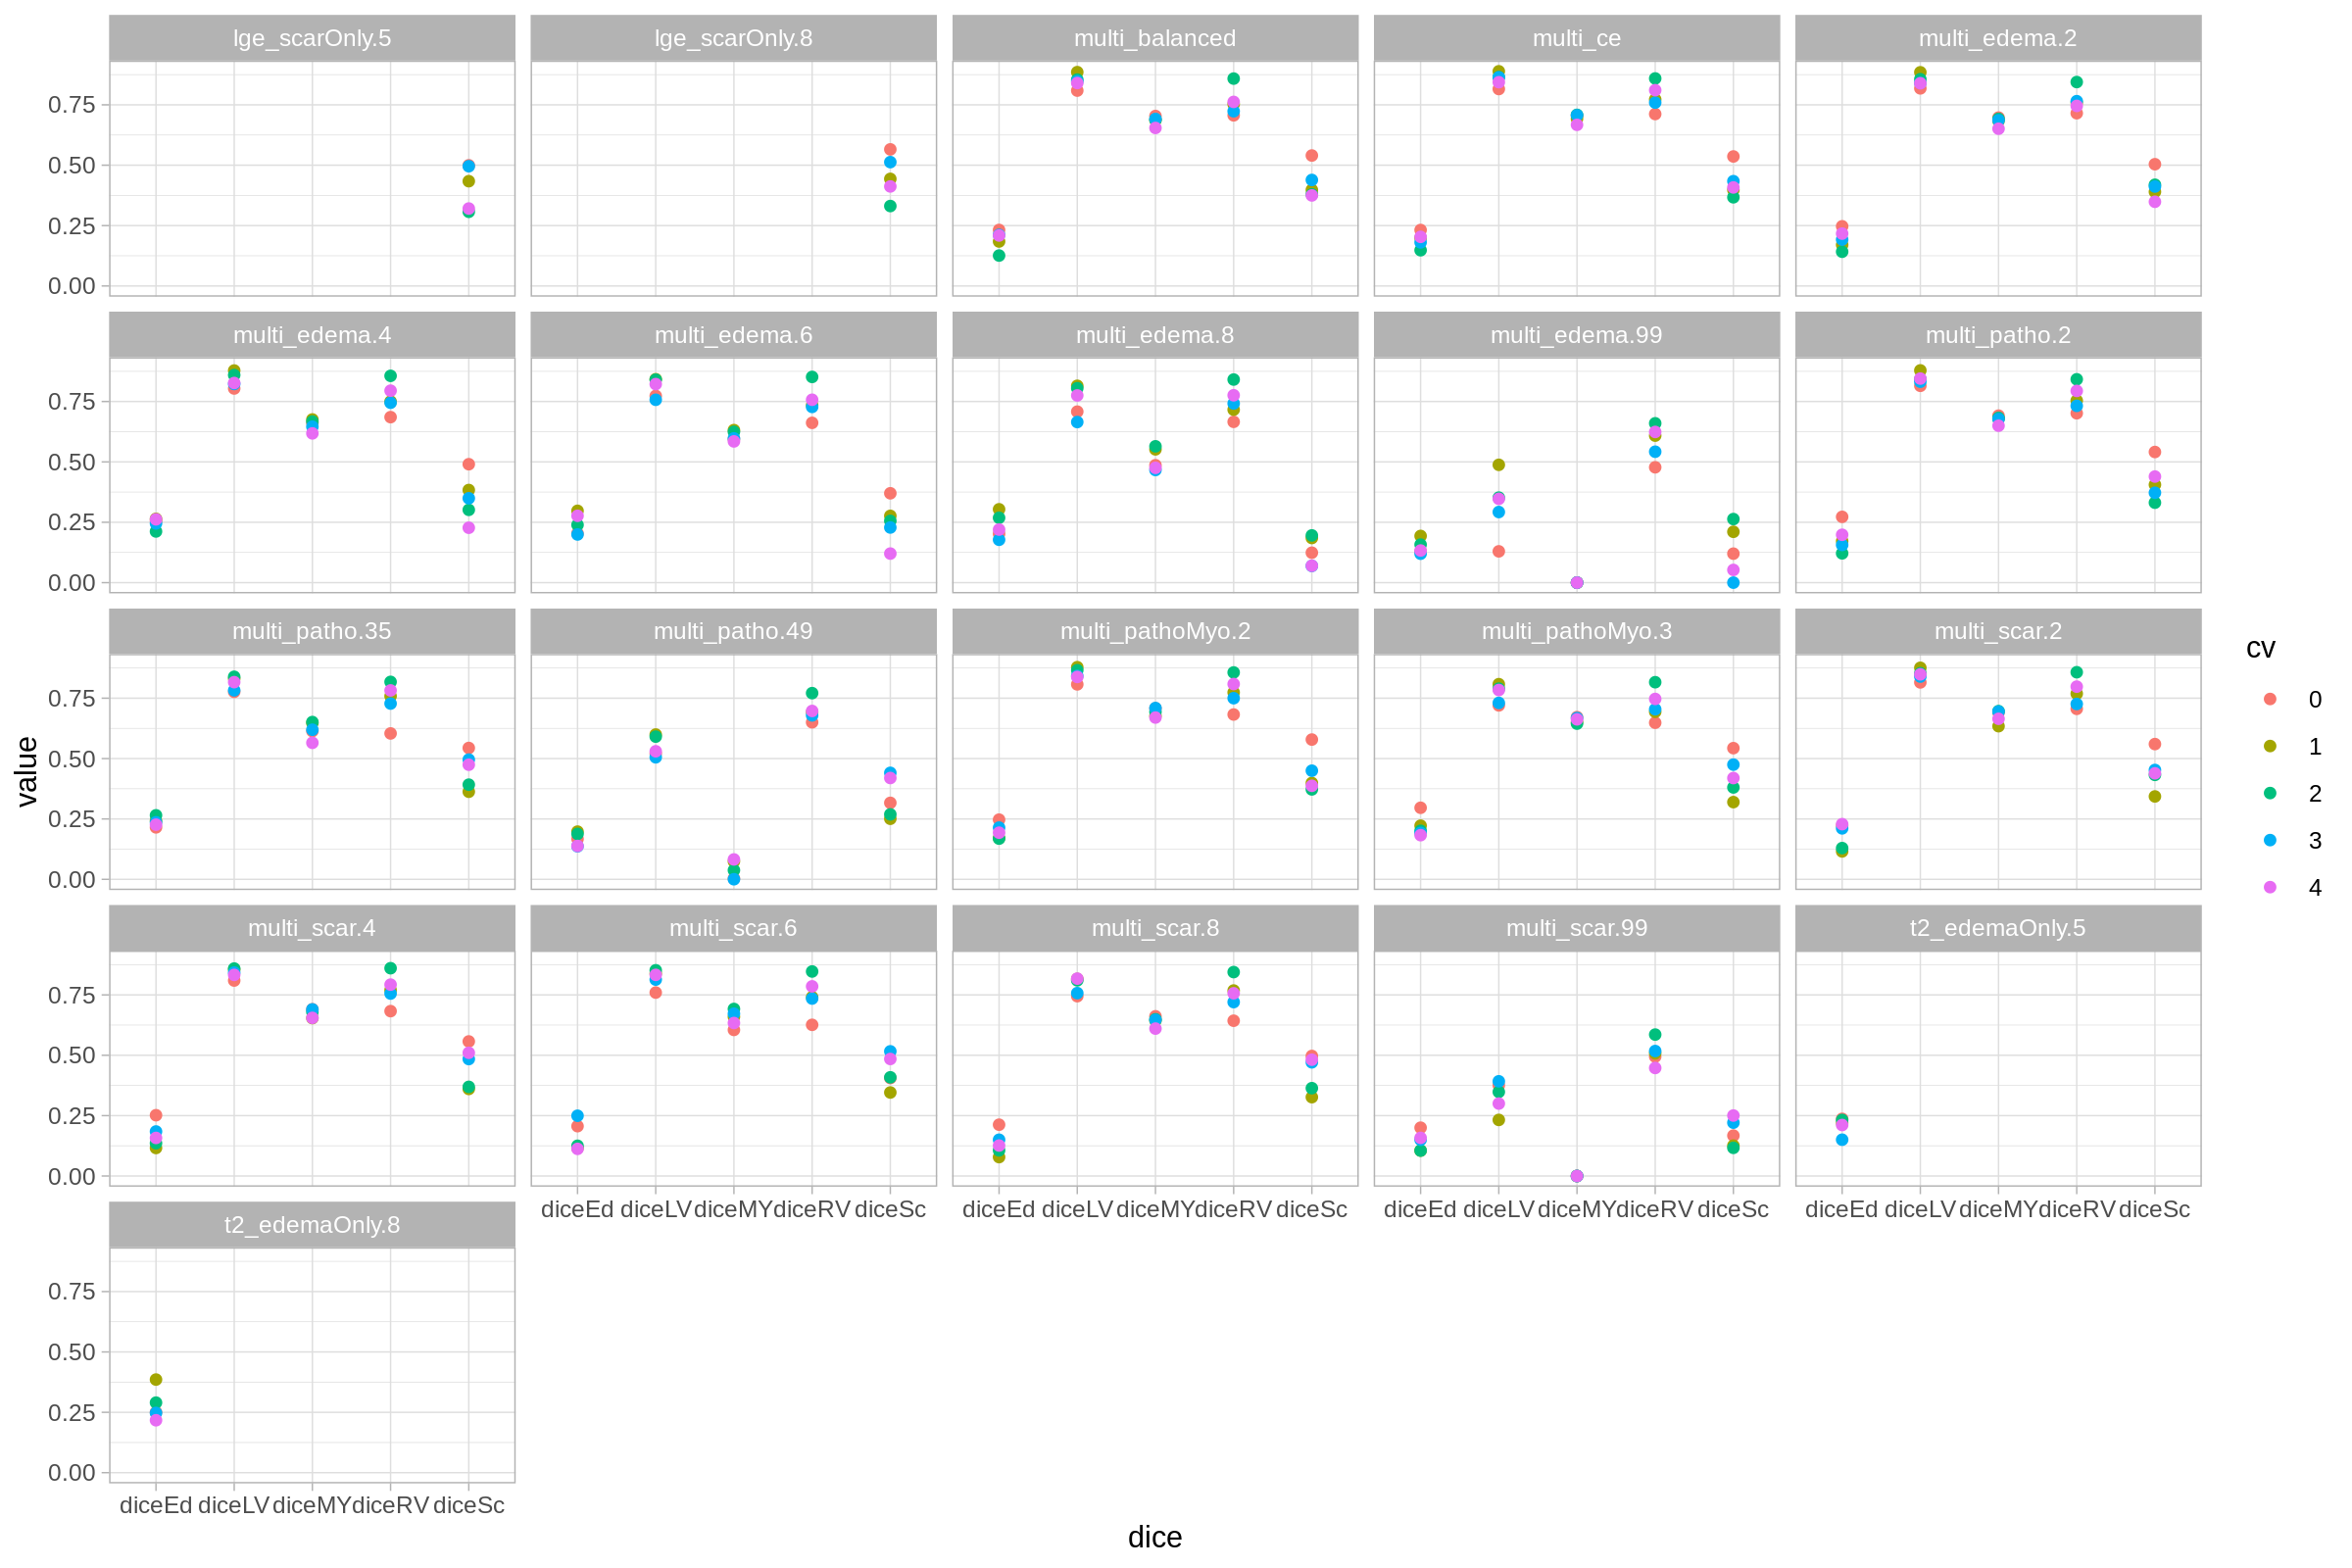

In [18]:
data %>%
    filter(epoch==30) %>%
    pivot_longer(starts_with("dice"), "dice", "score") %>%
    ggplot(aes(dice,value,color=cv)) +
        geom_point() +
        facet_wrap(run~.)

### Compare model performance on Edema and Scar

Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


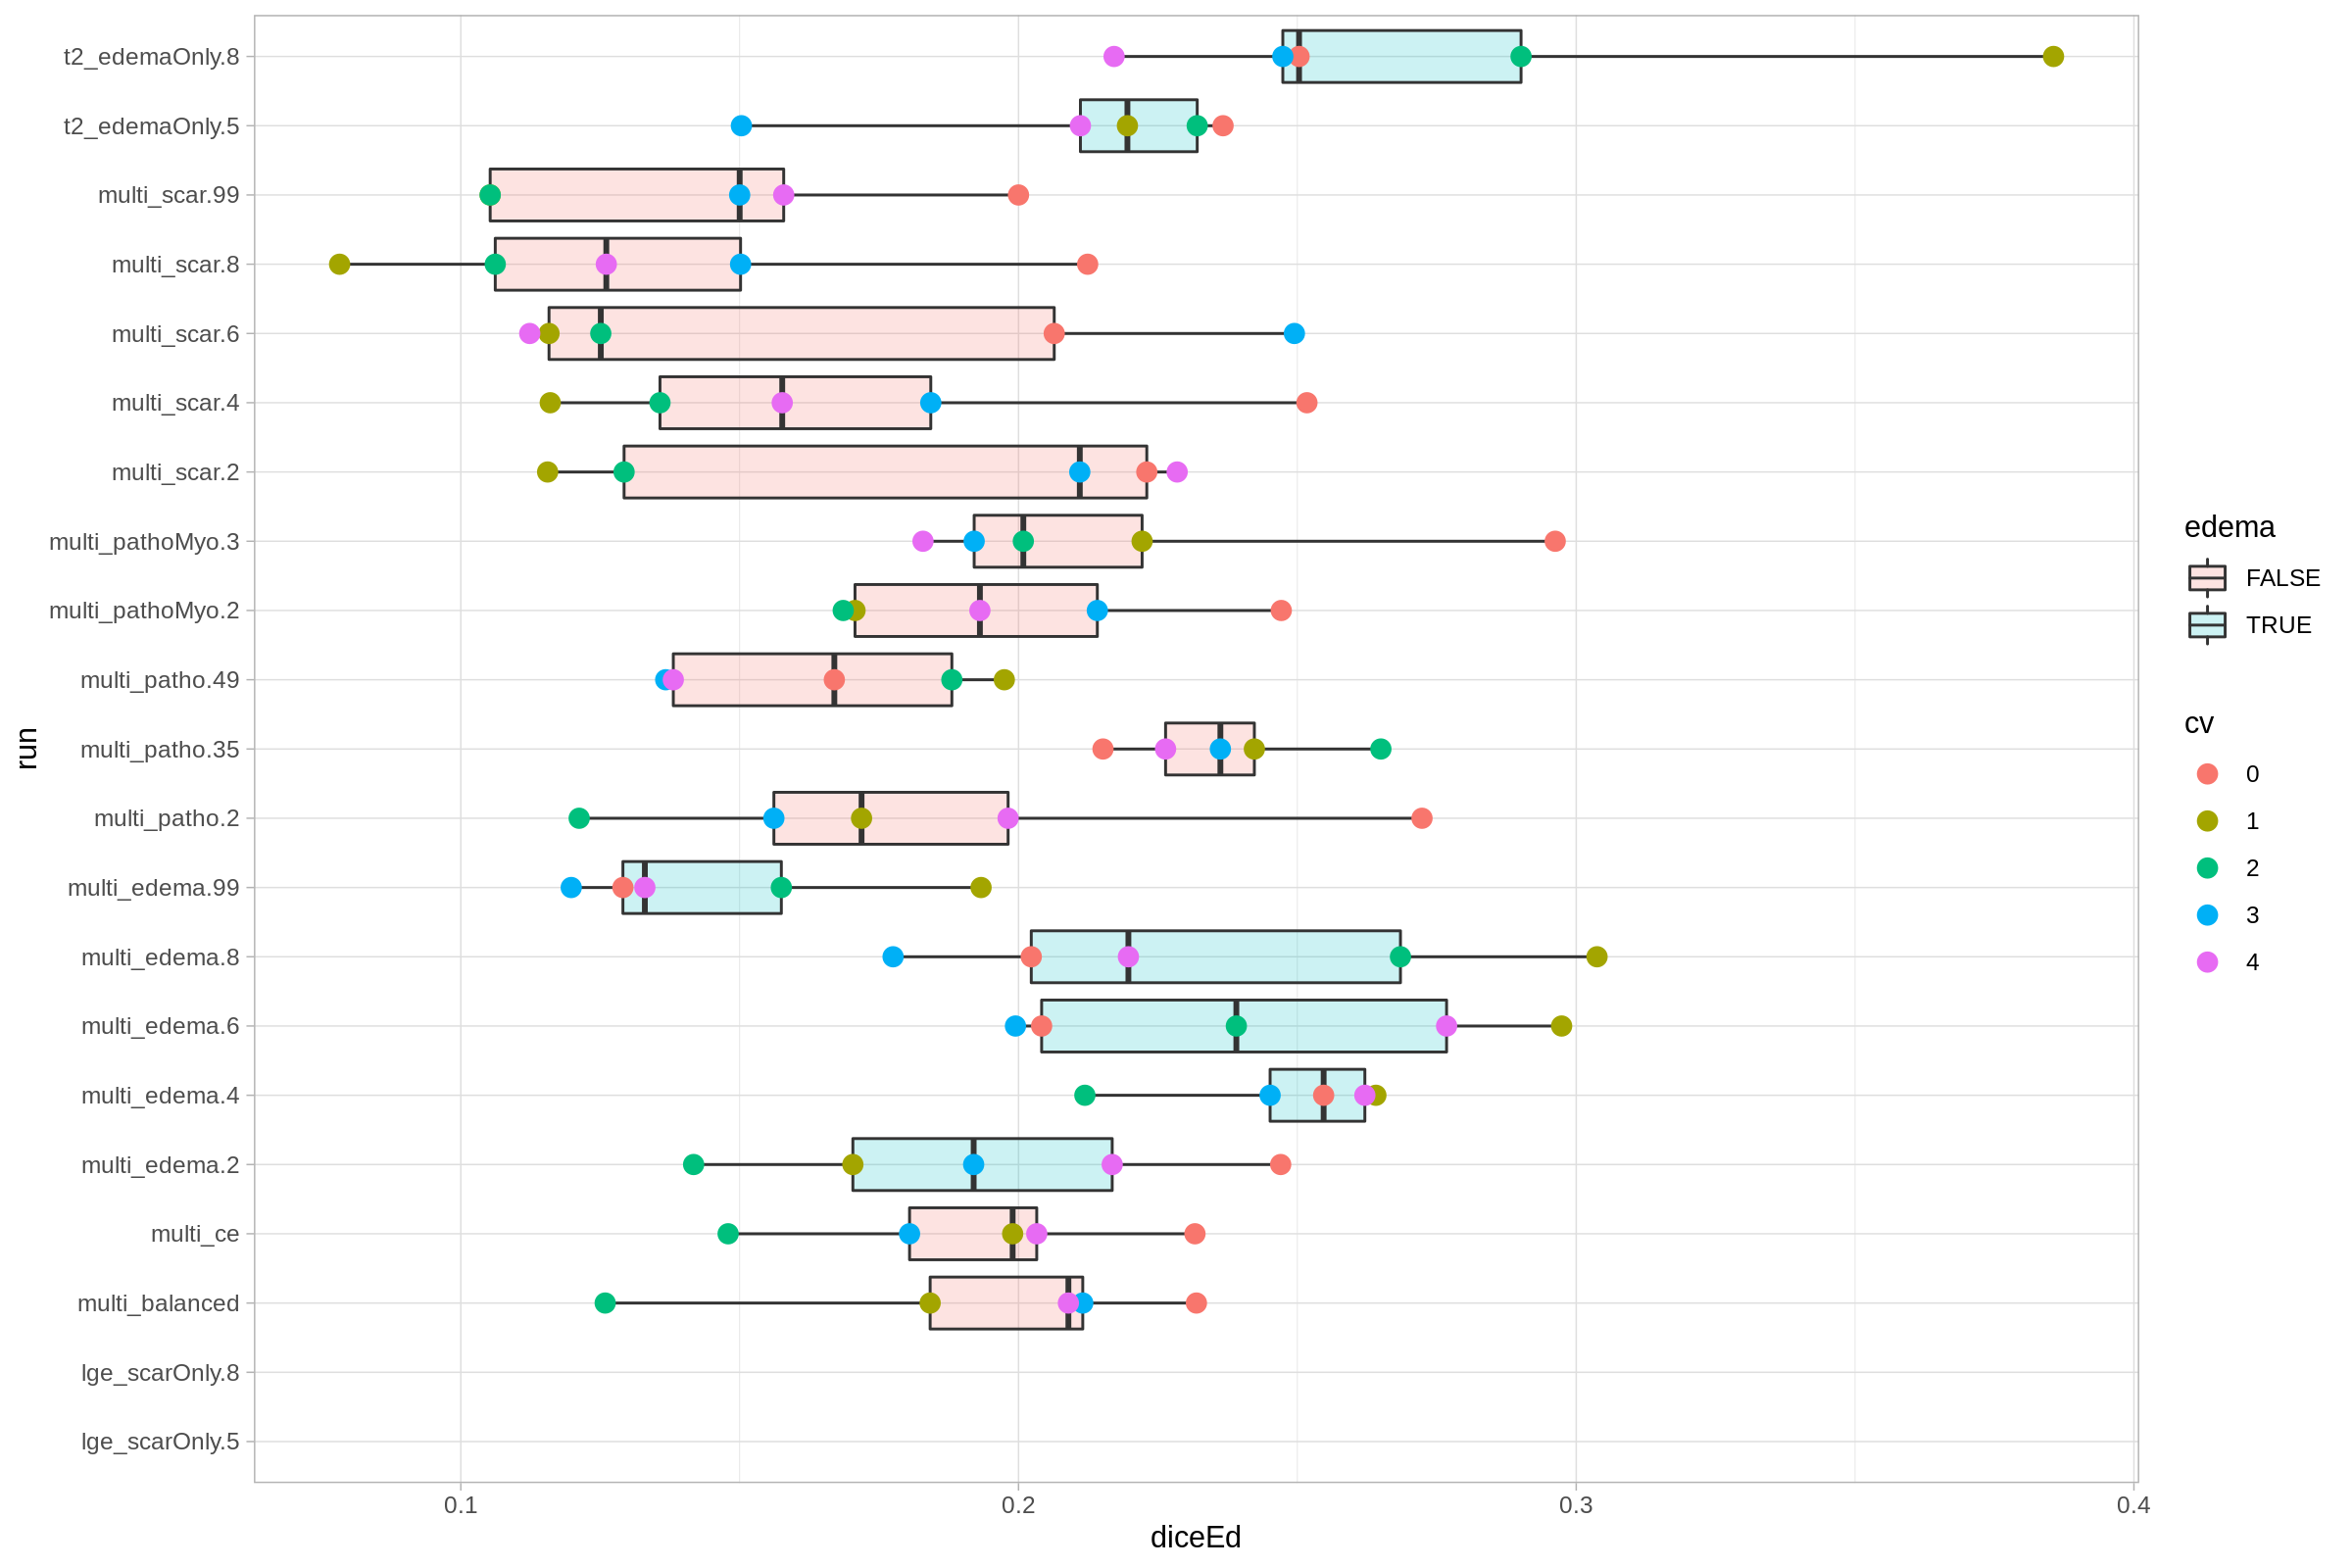

In [19]:
data %>%
    mutate(edema = str_detect(run,"edema")) %>%
    filter(epoch==30) %>%
    ggplot(aes(run,diceEd)) +
        geom_boxplot(aes(fill=edema), alpha=.2, coef=Inf) +
        geom_point(aes(color=cv), size=3) +
        coord_flip()

Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


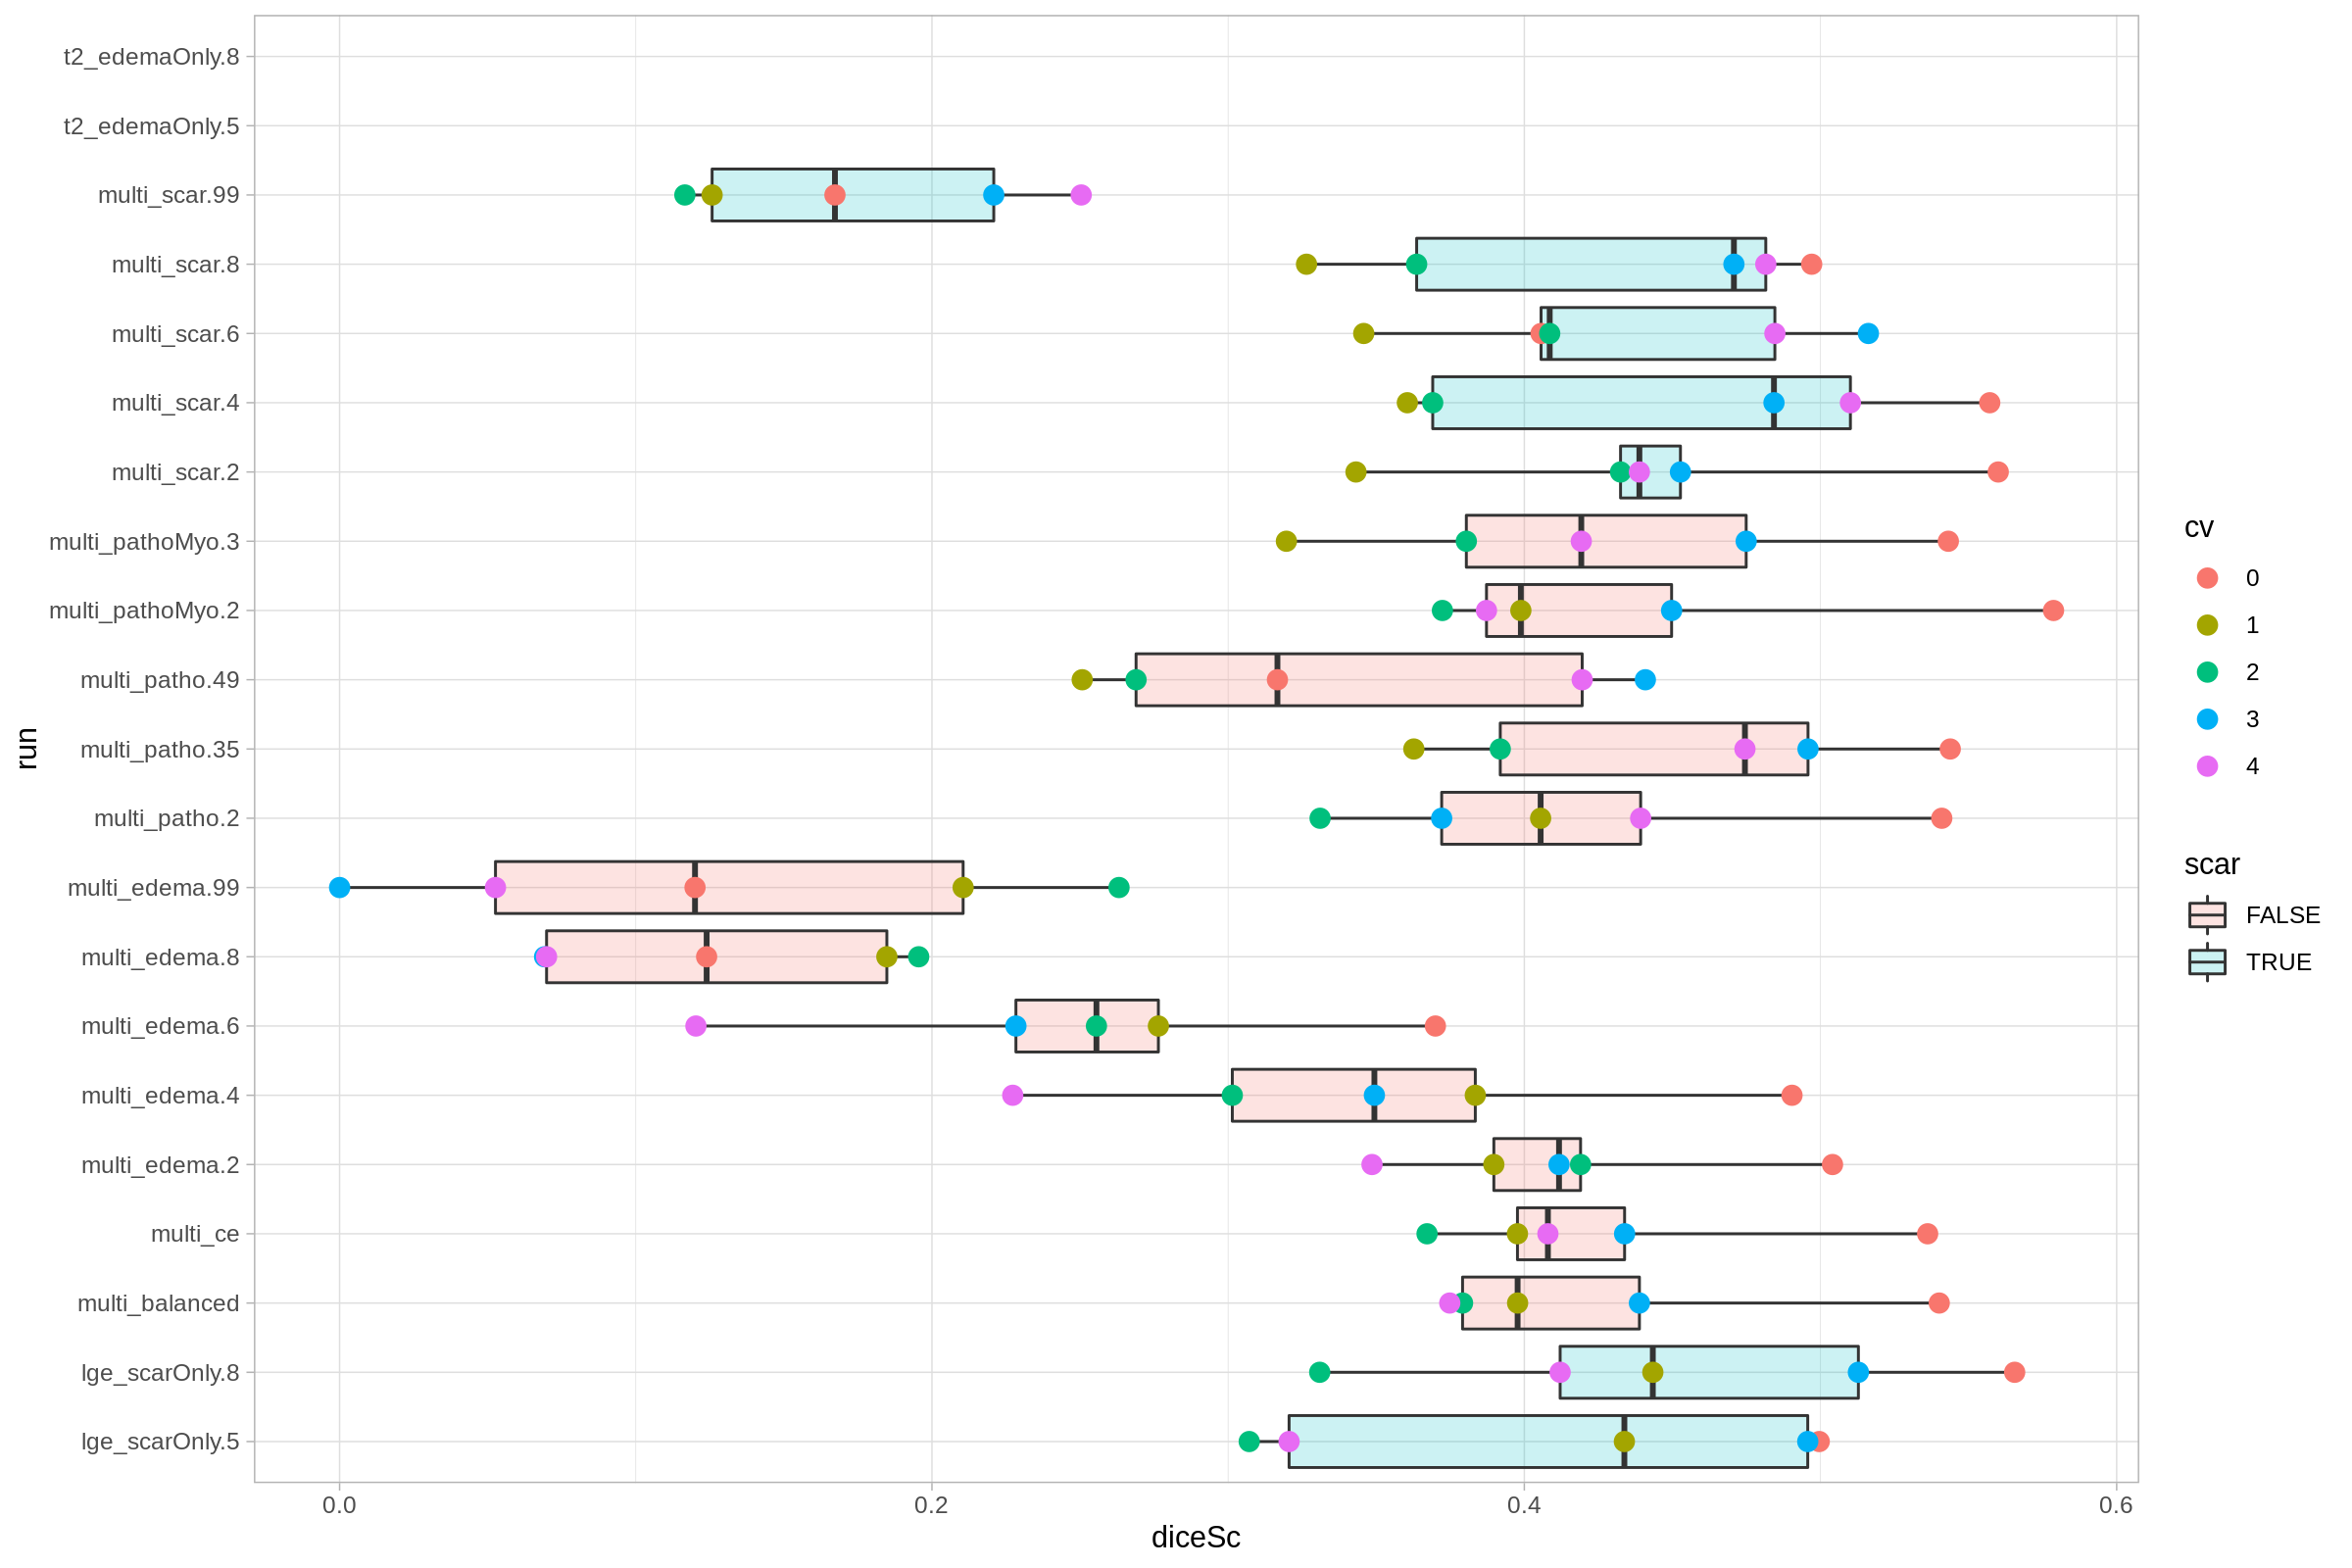

In [20]:
data %>%
    filter(epoch==30) %>%
    mutate(scar = str_detect(run,"scar")) %>%
    ggplot(aes(run,diceSc)) +
        geom_boxplot(aes(fill=scar), alpha=.2, coef=Inf) +
        geom_point(aes(color=cv),size=3) +
        coord_flip()

## Sonstiges

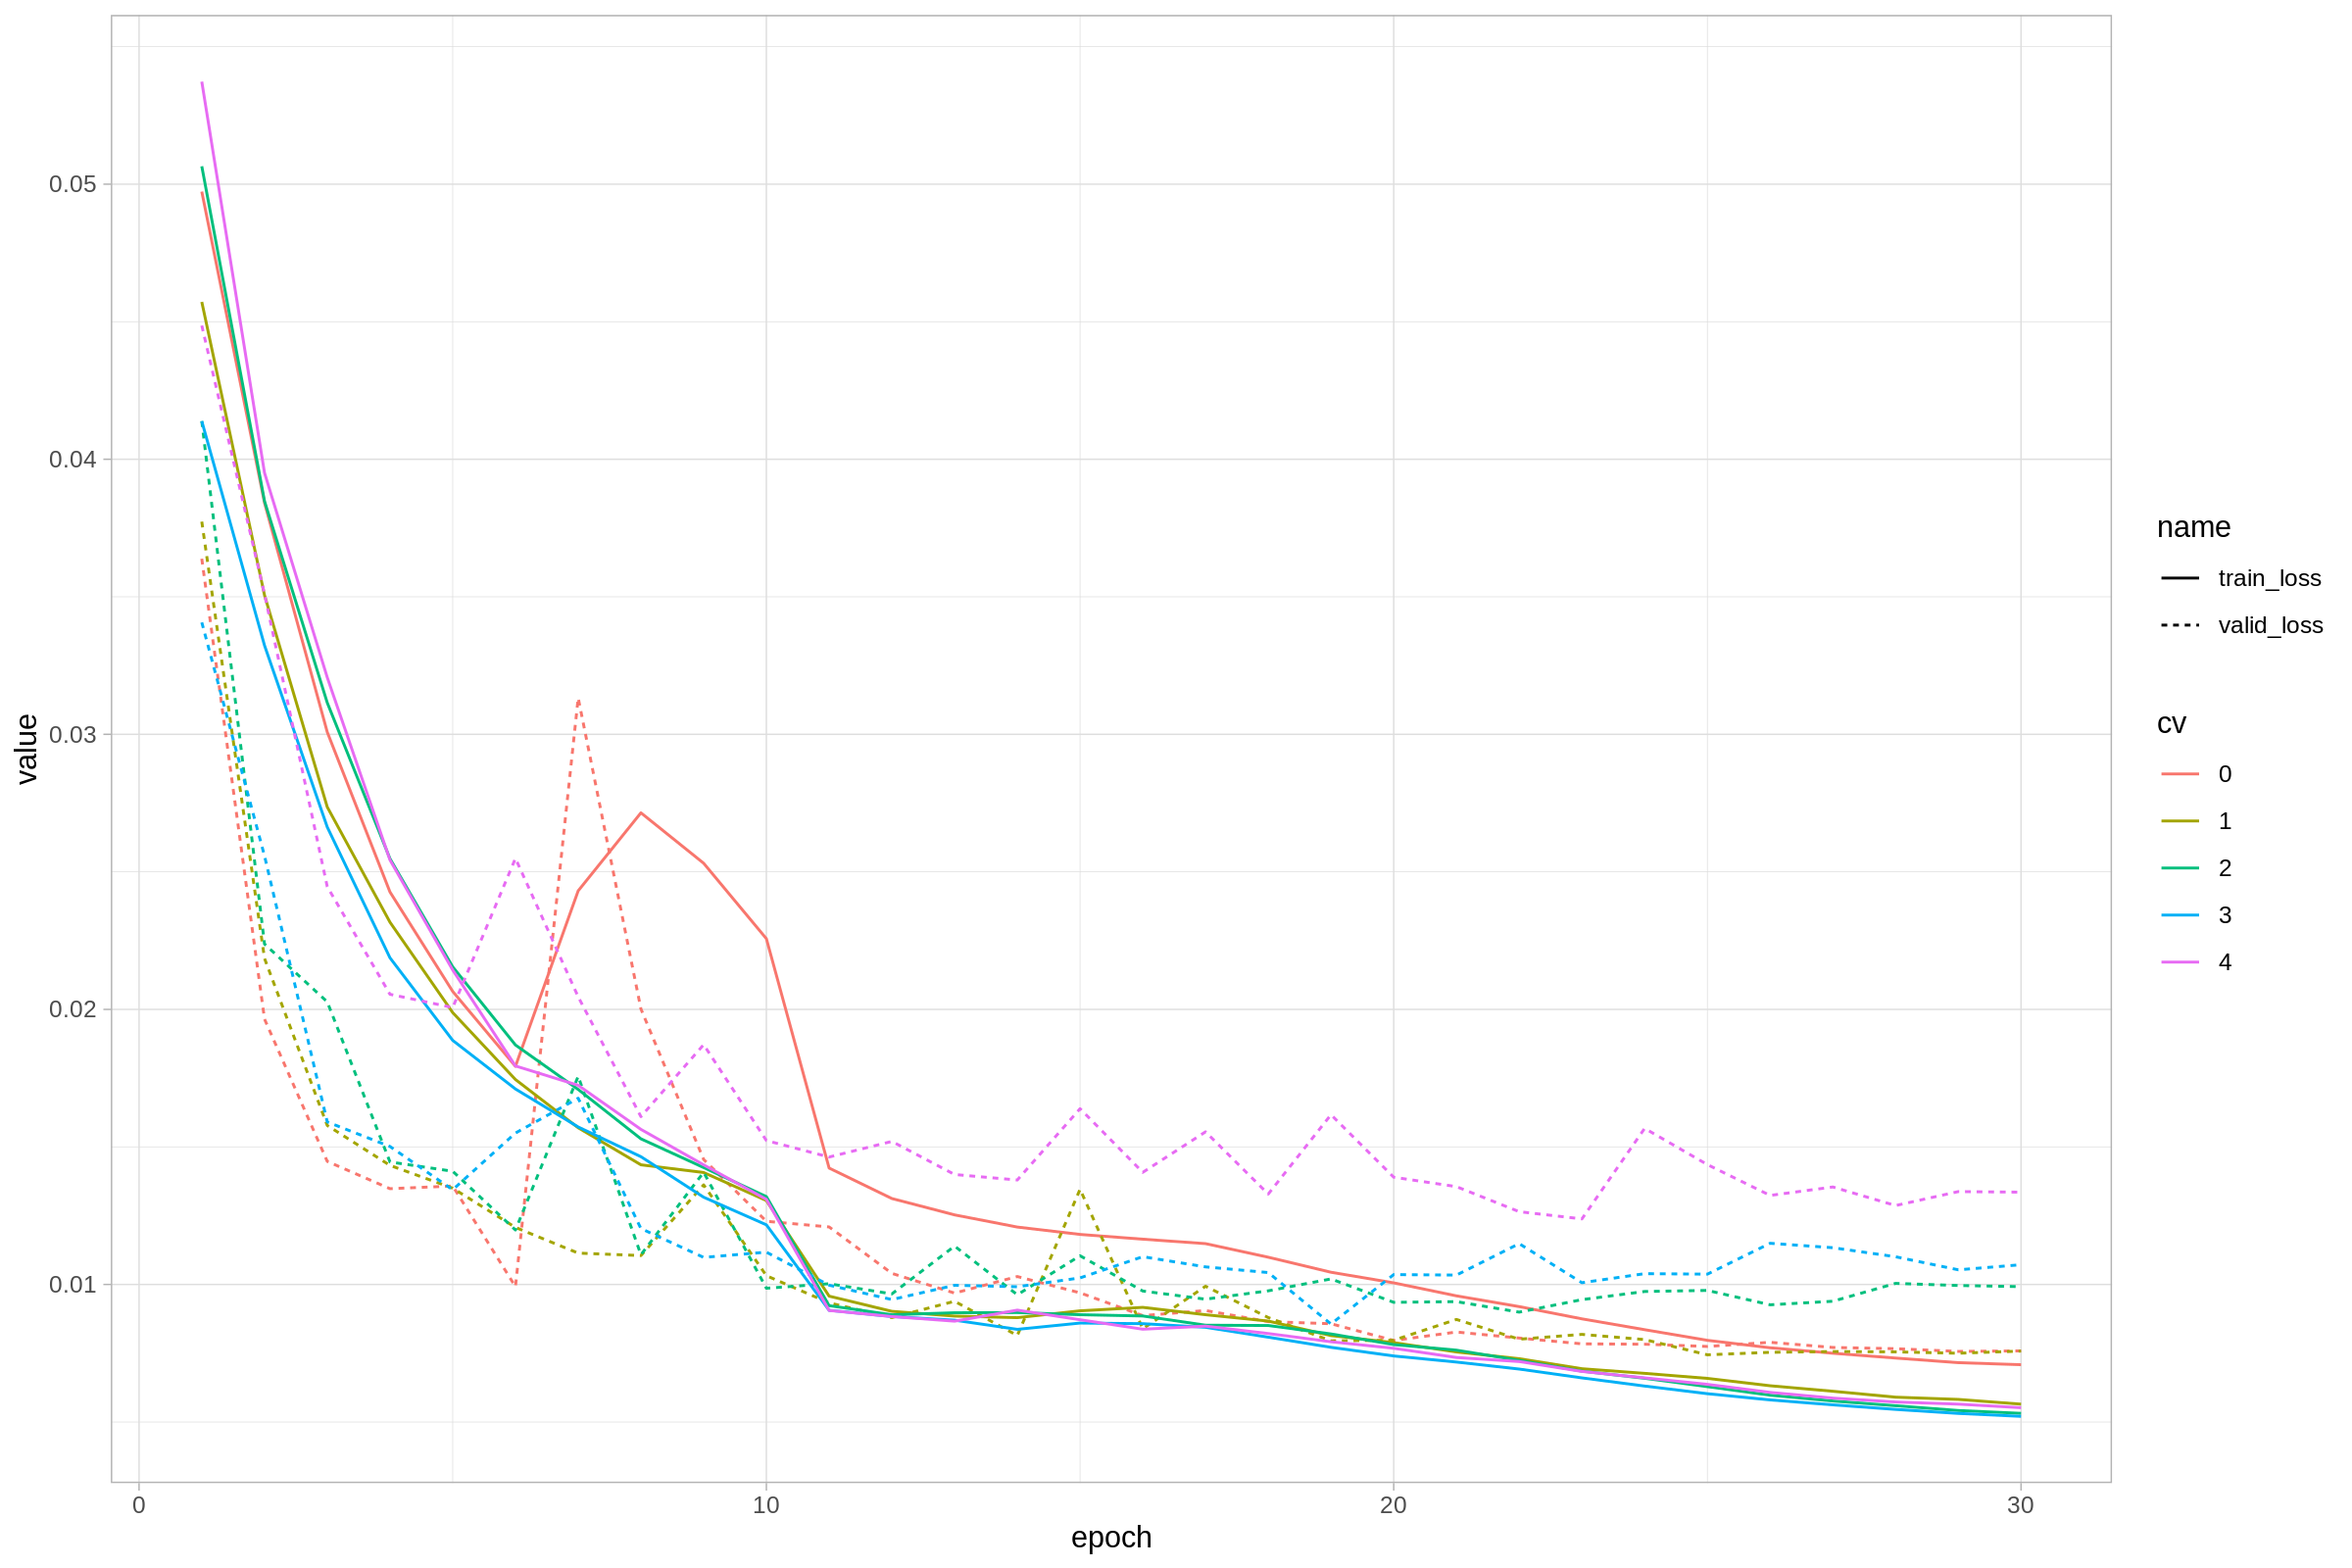

In [21]:
data %>%
    filter(run == "multi_patho.35") %>%
    pivot_longer(contains("loss")) %>%
    ggplot(aes(epoch,value,color=cv,lty=name)) +
        geom_line()

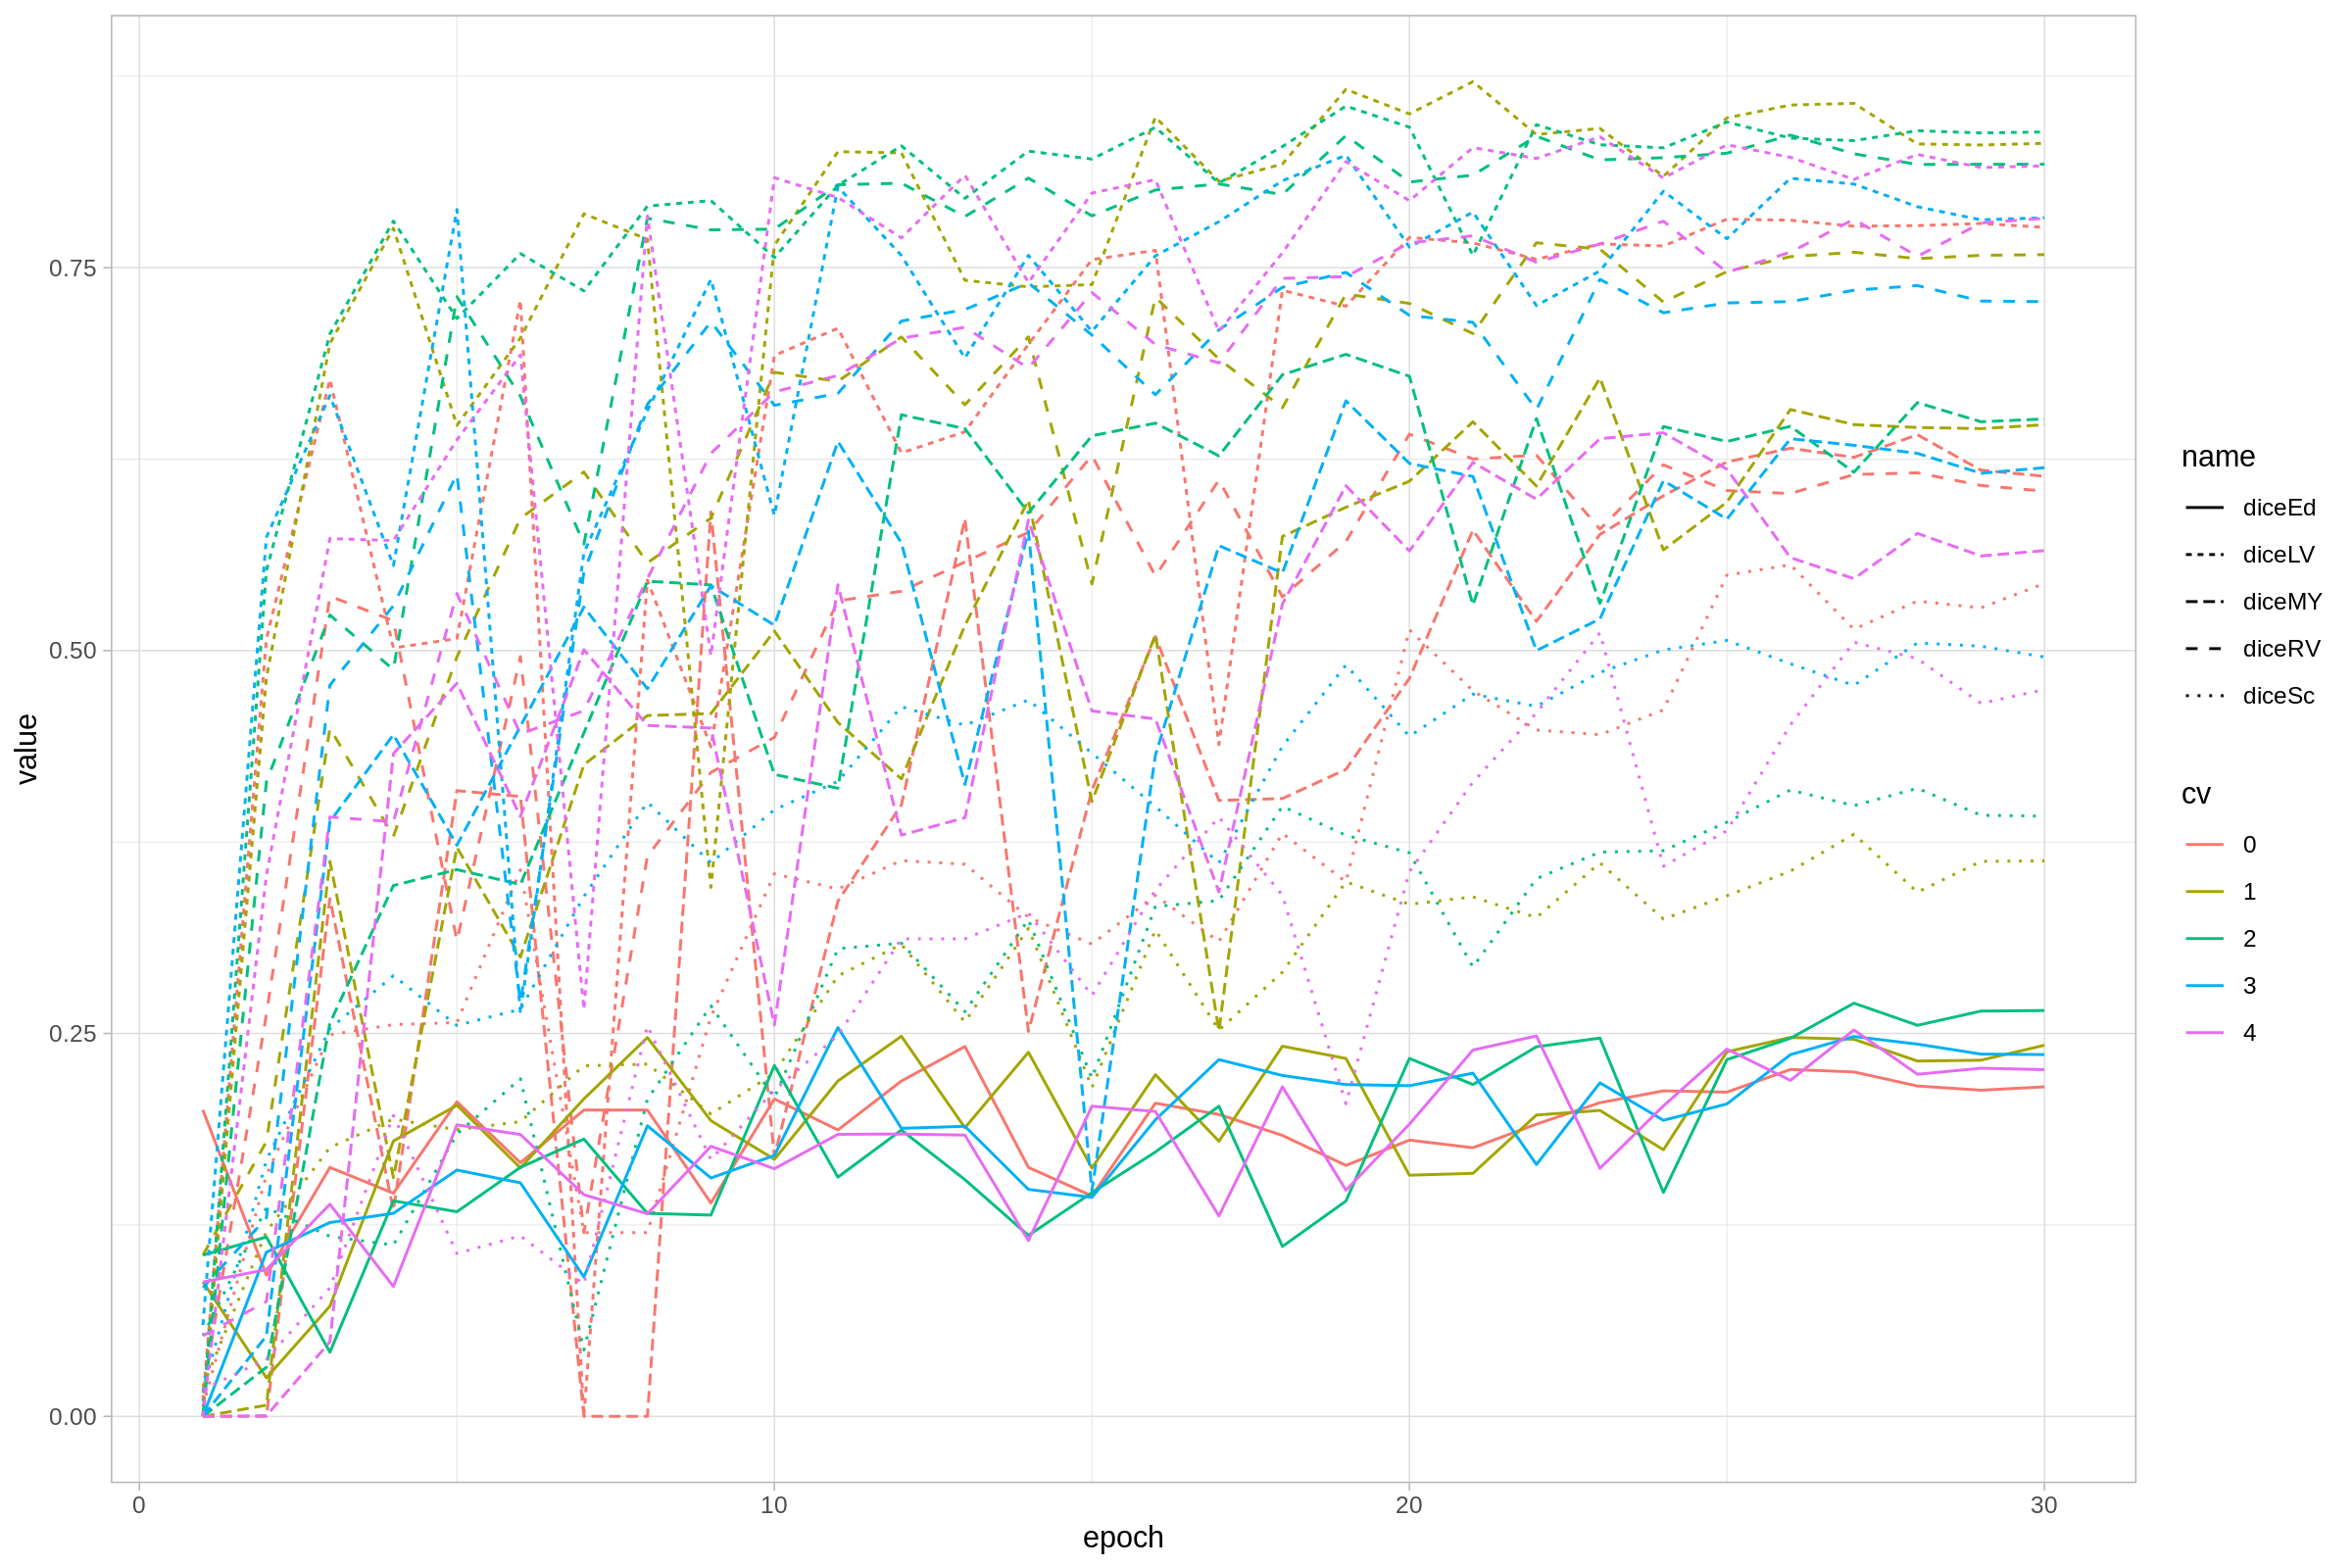

In [22]:
data %>%
    filter(run == "multi_patho.35") %>%
    pivot_longer(contains("dice")) %>%
    ggplot(aes(epoch,value,color=cv,lty=name)) +
        geom_line()

## Longer training

In [23]:
multi_long <- read_csv("../logs_20_40/combined_multi.csv") %>%
    separate(run, c("in","focus","cv"), "_", remove=FALSE) %>%
    separate(focus, c("focus","weight"), "\\.", fill = "right") %>%
    mutate(cv = str_remove(cv, "cv"), run = str_remove(run, "_cv."))
lge_long <- read_csv("../logs_20_40/combined_lge.csv") %>%
    separate(run, c("in","focus","cv"), "_", remove=FALSE) %>%
    separate(focus, c("focus","weight"), "\\.", fill = "right") %>%
    mutate(cv = str_remove(cv, "cv"), run = str_remove(run, "_cv.")) %>%
    rename(diceSc = diceFG)
t2_long <- read_csv("../logs_20_40/combined_t2.csv") %>%
    separate(run, c("in","focus","cv"), "_", remove=FALSE) %>%
    separate(focus, c("focus","weight"), "\\.", fill = "right") %>%
    mutate(cv = str_remove(cv, "cv"), run = str_remove(run, "_cv.")) %>%
    rename(diceEd = diceFG)
long <- bind_rows(multi_long,lge_long,t2_long)

Parsed with column specification:
cols(
  run = col_character(),
  epoch = col_double(),
  train_loss = col_double(),
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double(),
  time = col_time(format = "")
)

Parsed with column specification:
cols(
  run = col_character(),
  epoch = col_double(),
  train_loss = col_double(),
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceFG = col_double(),
  time = col_time(format = "")
)

Parsed with column specification:
cols(
  run = col_character(),
  epoch = col_double(),
  train_loss = col_double(),
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceFG = col_double(),
  time = col_time(format = "")
)



In [24]:
long

run            in    focus     weight cv epoch train_loss  valid_loss 
1    multi_ce       multi ce        NA     0   1    0.9819551   0.6118782  
2    multi_ce       multi ce        NA     0   2    0.6764400   0.3797100  
3    multi_ce       multi ce        NA     0   3    0.5347855   0.2771505  
4    multi_ce       multi ce        NA     0   4    0.4346019   0.2839430  
5    multi_ce       multi ce        NA     0   5    0.3723729   0.2031246  
6    multi_ce       multi ce        NA     0   6    0.3212776   0.2008199  
7    multi_ce       multi ce        NA     0   7    0.2863492   0.1812387  
8    multi_ce       multi ce        NA     0   8    0.2554004   0.1531941  
9    multi_ce       multi ce        NA     0   9    0.2266568   0.1613739  
10   multi_ce       multi ce        NA     0  10    0.2102192   0.1491719  
11   multi_ce       multi ce        NA     0  11    0.1972469   0.1856676  
12   multi_ce       multi ce        NA     0  12    0.1857093   0.1670075  
13   multi_ce       multi ce        NA     0  13    0.2423384   0.1923772  
14   multi_ce       multi ce        NA     0  14    0.2254081   0.1461056  
15   multi_ce       multi ce        NA     0  15    0.2045689   0.1356049  
16   multi_ce       multi ce        NA     0  16    0.1874135   0.1443812  
17   multi_ce       multi ce        NA     0  17    0.1751818   0.1364270  
18   multi_ce       multi ce        NA     0  18    0.1626125   0.1501551  
19   multi_ce       multi ce        NA     0  19    0.1538409   0.1218893  
20   multi_ce       multi ce        NA     0  20    0.1476849   0.1297517  
21   multi_ce       multi ce        NA     0  21    0.1198751   0.1229358  
22   multi_ce       multi ce        NA     0  22    0.1177230   0.1247119  
23   multi_ce       multi ce        NA     0  23    0.1164636   0.1189821  
24   multi_ce       multi ce        NA     0  24    0.1143881   0.1249271  
25   multi_ce       multi ce        NA     0  25    0.1149361   0.1191963  
26   multi_ce       multi ce        NA     0  26    0.1141443   0.1279429  
27   multi_ce       multi ce        NA     0  27    0.1124037   0.1150833  
28   multi_ce       multi ce        NA     0  28    0.1130538   0.1189526  
29   multi_ce       multi ce        NA     0  29    0.1122666   0.1177242  
30   multi_ce       multi ce        NA     0  30    0.1135189   0.1167791  
⋮    ⋮              ⋮     ⋮         ⋮      ⋮  ⋮     ⋮           ⋮          
1771 t2_edemaOnly.8 t2    edemaOnly 8      4  31    0.002378156 0.006533385
1772 t2_edemaOnly.8 t2    edemaOnly 8      4  32    0.002416017 0.005006207
1773 t2_edemaOnly.8 t2    edemaOnly 8      4  33    0.002309792 0.005977009
1774 t2_edemaOnly.8 t2    edemaOnly 8      4  34    0.002224337 0.004345796
1775 t2_edemaOnly.8 t2    edemaOnly 8      4  35    0.002154968 0.007196763
1776 t2_edemaOnly.8 t2    edemaOnly 8      4  36    0.002112737 0.004747451
1777 t2_edemaOnly.8 t2    edemaOnly 8      4  37    0.002138077 0.004675994
1778 t2_edemaOnly.8 t2    edemaOnly 8      4  38    0.002063330 0.006147441
1779 t2_edemaOnly.8 t2    edemaOnly 8      4  39    0.001962153 0.004960076
1780 t2_edemaOnly.8 t2    edemaOnly 8      4  40    0.001963395 0.005554951
1781 t2_edemaOnly.8 t2    edemaOnly 8      4  41    0.001876522 0.006721060
1782 t2_edemaOnly.8 t2    edemaOnly 8      4  42    0.001917492 0.007147512
1783 t2_edemaOnly.8 t2    edemaOnly 8      4  43    0.001880601 0.005623873
1784 t2_edemaOnly.8 t2    edemaOnly 8      4  44    0.001838687 0.006196058
1785 t2_edemaOnly.8 t2    edemaOnly 8      4  45    0.001791661 0.005999102
1786 t2_edemaOnly.8 t2    edemaOnly 8      4  46    0.001780971 0.007062689
1787 t2_edemaOnly.8 t2    edemaOnly 8      4  47    0.001744097 0.007091739
1788 t2_edemaOnly.8 t2    edemaOnly 8      4  48    0.001726125 0.005950269
1789 t2_edemaOnly.8 t2    edemaOnly 8      4  49    0.001736735 0.006623222
1790 t2_edemaOnly.8 t2    edemaOnly 8      4  50    0.001712070 0.006825803
1791 t2_edemaOnly.8 t2    edemaOnly 8      4  51    0

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 721 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 721 rows containing missing values (geom_point).”


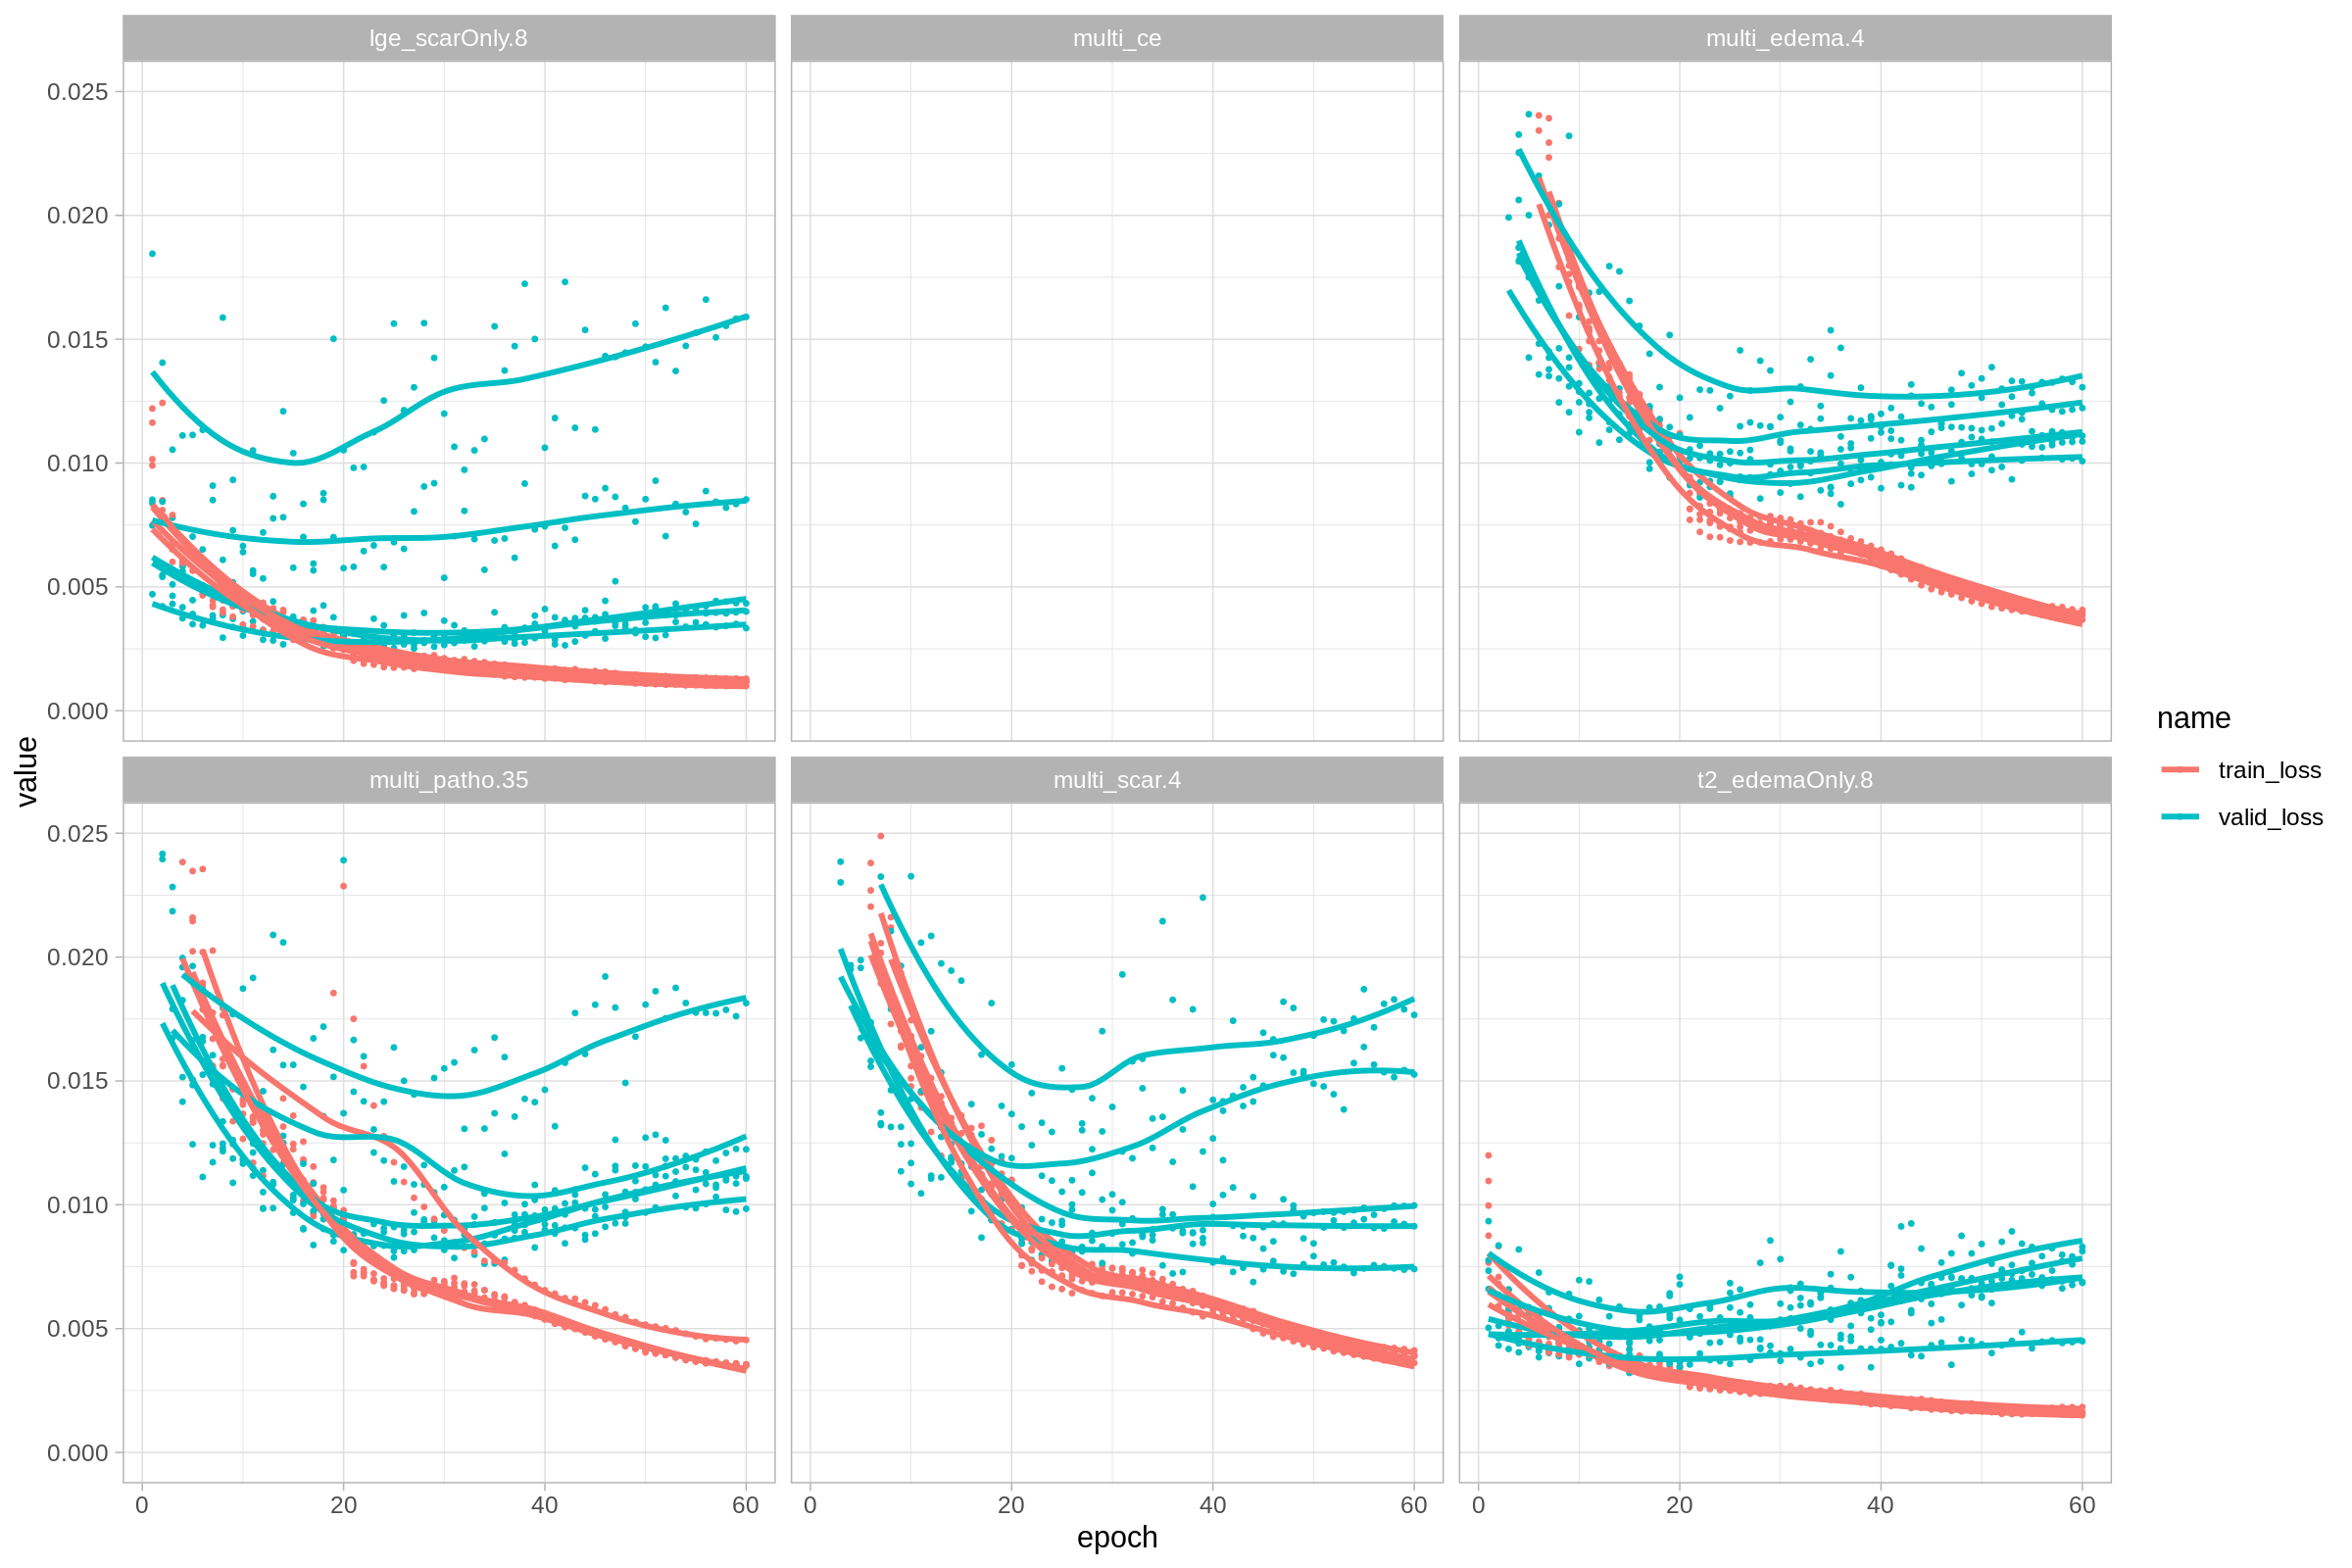

In [28]:
long %>%
    pivot_longer(contains("loss")) %>%
    #filter(focus != "ce", startsWith(run, "multi")) %>%
    ggplot(aes(epoch, value, pty=cv, color=name))+ #, shape=cv)) +
        geom_point(size=.5) +
        geom_smooth(se=F) +
        facet_wrap(.~run) +
        ylim(0,.025)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 2400 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2400 rows containing missing values (geom_point).”


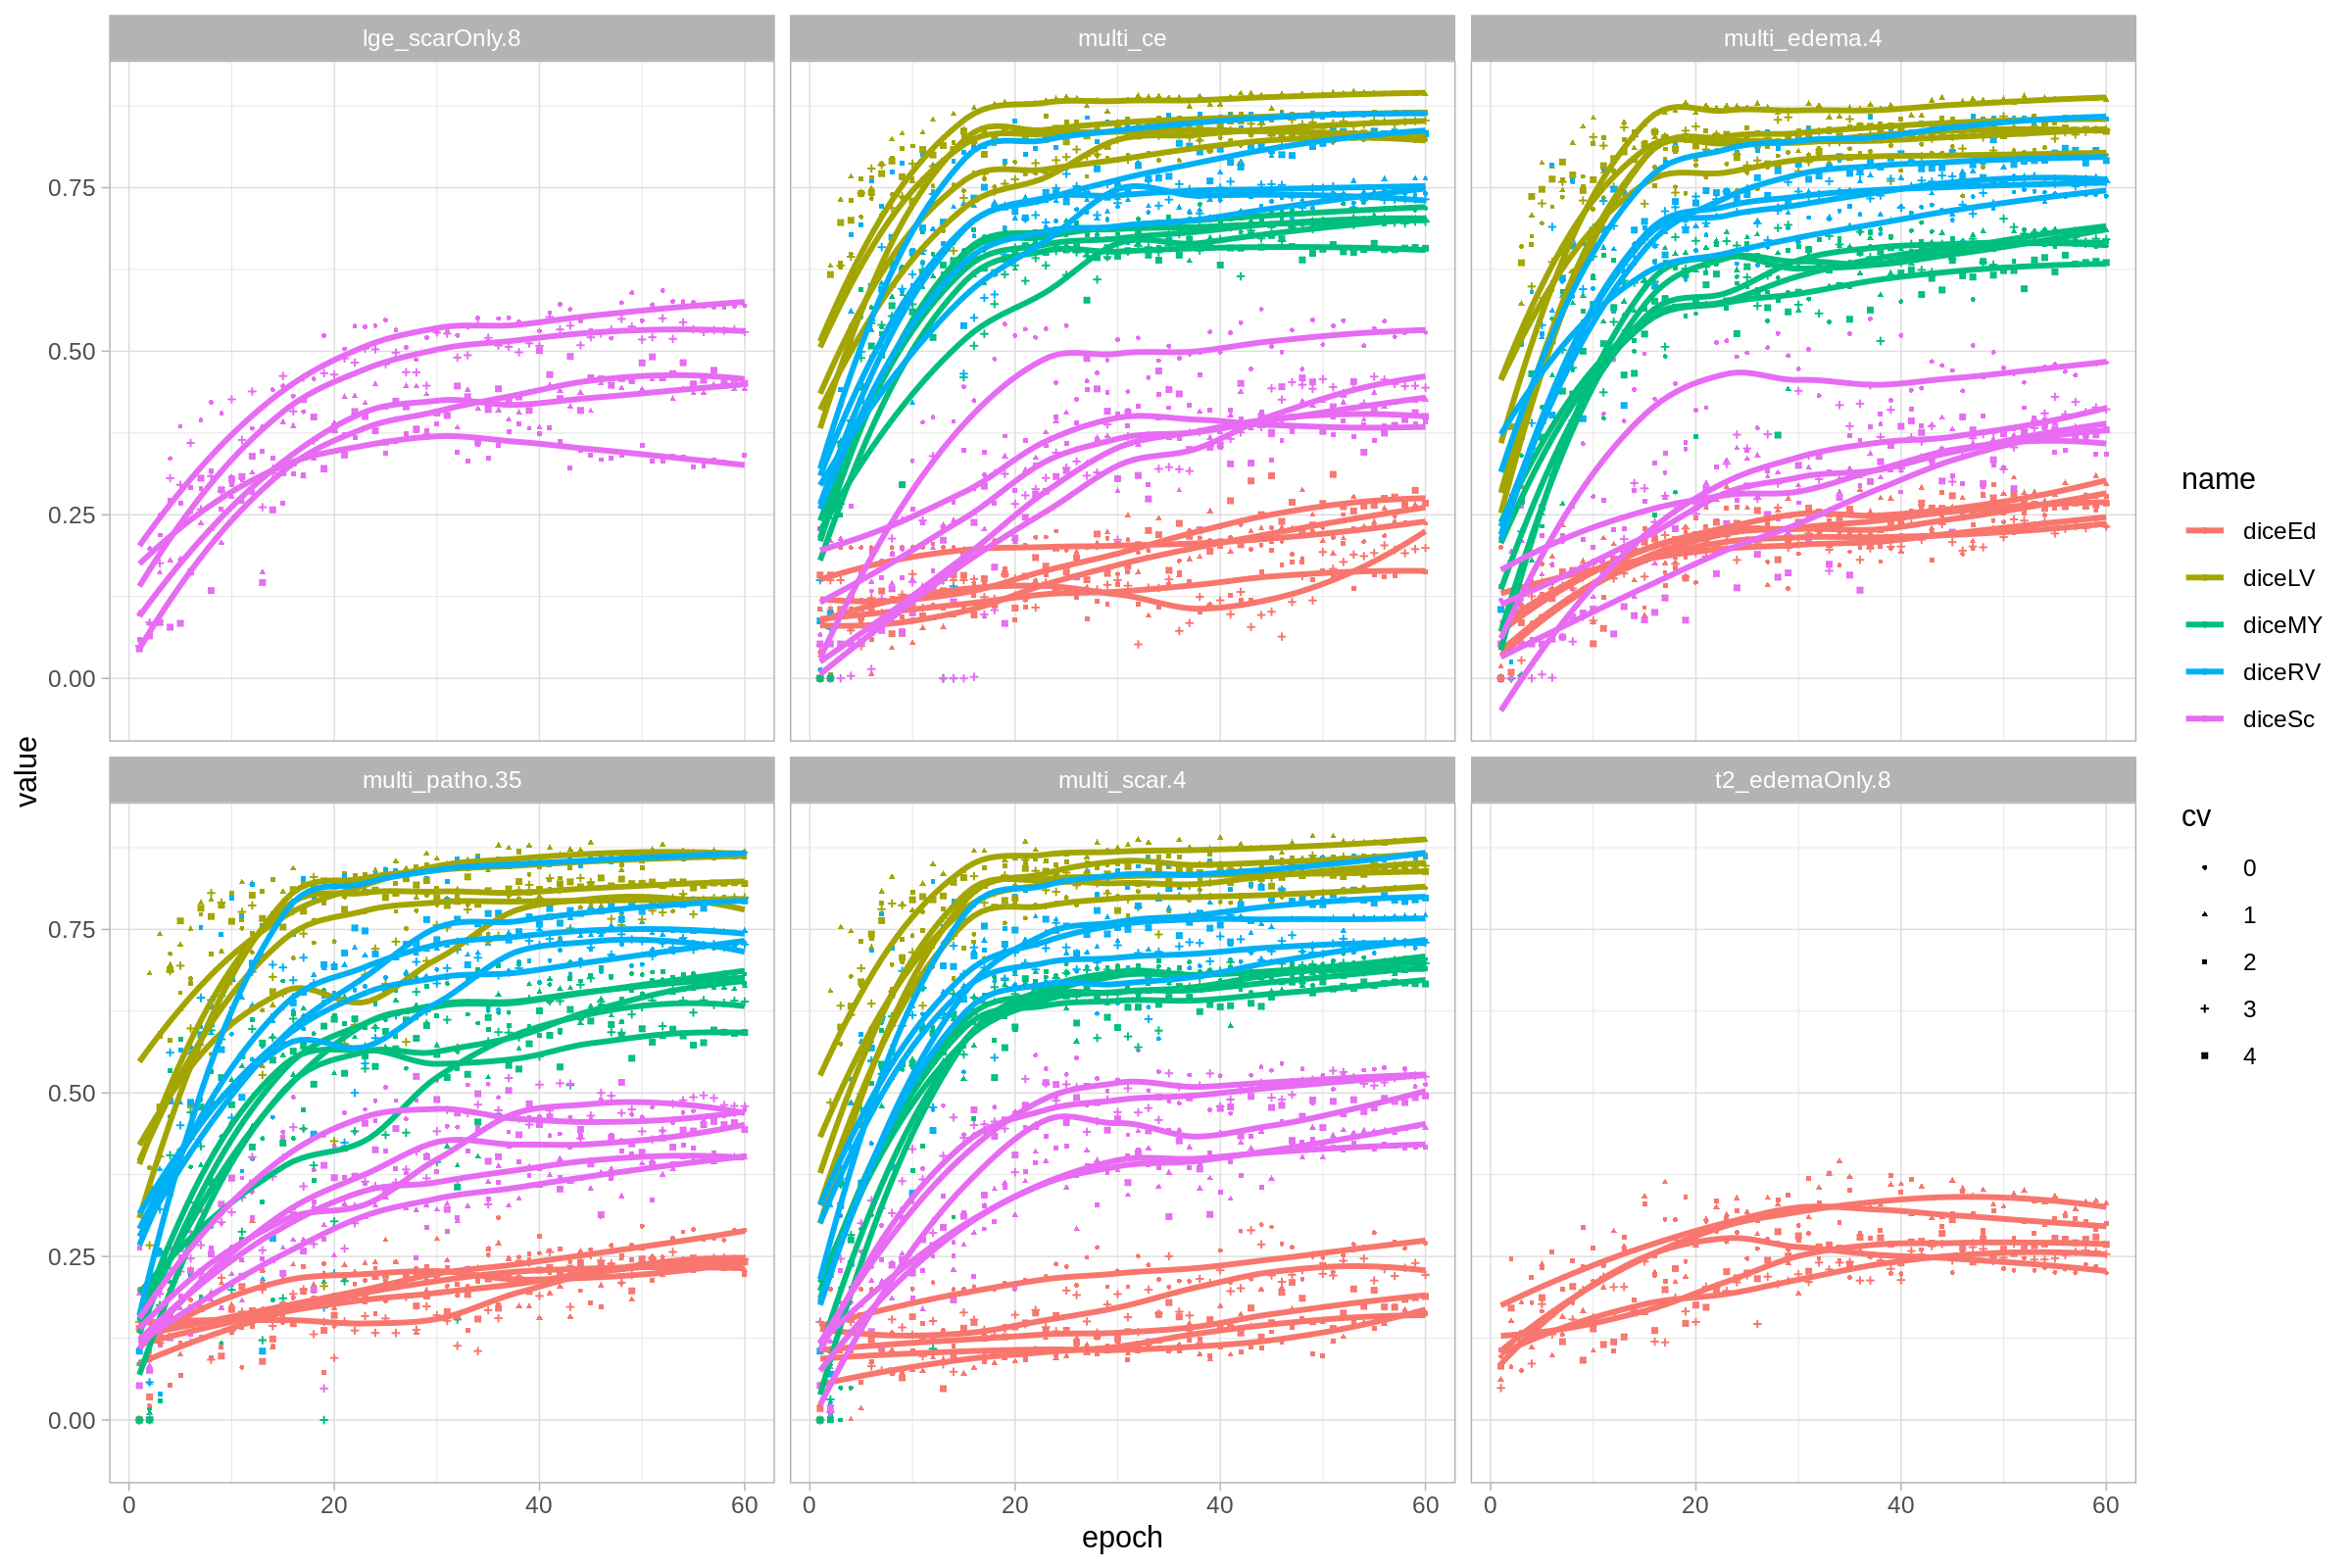

In [30]:
long %>%
    pivot_longer(contains("dice")) %>%
    #filter(focus != "ce", startsWith(run, "multi")) %>%
    ggplot(aes(epoch, value, color=name, shape=cv))+ #, shape=cv)) +
        geom_point(size=.5) +
        #geom_line() +
        geom_smooth(se=FALSE) +
        facet_wrap(.~run)

In [31]:
long %>% filter(epoch==60)

run            in    focus     weight cv epoch train_loss  valid_loss 
1  multi_ce       multi ce        NA     0  60    0.066956460 0.119199269
2  multi_ce       multi ce        NA     1  60    0.062177032 0.107159451
3  multi_ce       multi ce        NA     2  60    0.058565732 0.144905135
4  multi_ce       multi ce        NA     3  60    0.076892011 0.143421009
5  multi_ce       multi ce        NA     4  60    0.057930030 0.172709182
6  multi_edema.4  multi edema     4      0  60    0.004070498 0.010872643
7  multi_edema.4  multi edema     4      1  60    0.003858574 0.010078475
8  multi_edema.4  multi edema     4      2  60    0.003904033 0.012222368
9  multi_edema.4  multi edema     4      3  60    0.004013872 0.011098961
10 multi_edema.4  multi edema     4      4  60    0.003676269 0.013060811
11 multi_patho.35 multi patho     35     0  60    0.003541263 0.011057288
12 multi_patho.35 multi patho     35     1  60    0.003509529 0.009838386
13 multi_patho.35 multi patho     35     2  60    0.003510793 0.011142375
14 multi_patho.35 multi patho     35     3  60    0.004540140 0.012237900
15 multi_patho.35 multi patho     35     4  60    0.003561488 0.018143201
16 multi_scar.4   multi scar      4      0  60    0.004117639 0.009132290
17 multi_scar.4   multi scar      4      1  60    0.003939393 0.007404782
18 multi_scar.4   multi scar      4      2  60    0.003881215 0.009970764
19 multi_scar.4   multi scar      4      3  60    0.003895206 0.015261723
20 multi_scar.4   multi scar      4      4  60    0.003610736 0.017664120
21 lge_scarOnly.8 lge   scarOnly  8      0  60    0.001292361 0.004335372
22 lge_scarOnly.8 lge   scarOnly  8      1  60    0.001156917 0.003335062
23 lge_scarOnly.8 lge   scarOnly  8      2  60    0.001237840 0.004005848
24 lge_scarOnly.8 lge   scarOnly  8      3  60    0.001181805 0.008530742
25 lge_scarOnly.8 lge   scarOnly  8      4  60    0.001000414 0.015899088
26 t2_edemaOnly.8 t2    edemaOnly 8      0  60    0.001833100 0.008300016
27 t2_edemaOnly.8 t2    edemaOnly 8      1  60    0.001505130 0.006881158
28 t2_edemaOnly.8 t2    edemaOnly 8      2  60    0.001607172 0.008122806
29 t2_edemaOnly.8 t2    edemaOnly 8      3  60    0.001624773 0.004493564
30 t2_edemaOnly.8 t2    edemaOnly 8      4  60    0.001548973 0.006850230
   foreground_acc diceLV    diceMY    diceRV    diceEd    diceSc    time    
1  0.7612393      0.8233302 0.7189728 0.7409239 0.2369635 0.5288851 00:10:00
2  0.7917811      0.8925912 0.7026924 0.7638178 0.2665551 0.4263457 00:10:00
3  0.7876413      0.8651190 0.6998410 0.8643739 0.1635020 0.3916597 00:10:00
4  0.7525722      0.8528082 0.6979467 0.7322684 0.1993229 0.4442352 00:10:00
5  0.7257162      0.8329895 0.6574081 0.8323814 0.2678661 0.4003064 00:10:00
6  0.7309593      0.8003189 0.6612217 0.7370550 0.2322529 0.4826714 00:10:00
7  0.7843297      0.8843647 0.6850857 0.7630162 0.2967888 0.3807247 00:09:00
8  0.7629205      0.8545653 0.6670069 0.8543492 0.2779063 0.3432772 00:09:00
9  0.7328088      0.8386211 0.6712105 0.7584402 0.2317656 0.4112479 00:09:00
10 0.7047169      0.8361821 0.6355858 0.7914791 0.2680433 0.3797407 00:10:00
11 0.7399115      0.7965526 0.6815059 0.7296710 0.2901872 0.4746131 00:09:00
12 0.7744145      0.8692892 0.6632259 0.7480661 0.2285382 0.4016671 00:10:00
13 0.7669879      0.8608333 0.6676931 0.8659707 0.2227066 0.4038137 00:09:00
14 0.7168576      0.7990159 0.6396343 0.7270688 0.2464310 0.4797253 00:09:00
15 0.6786967      0.8200188 0.5924996 0.7937349 0.2419177 0.4439846 00:09:00
16 0.7546530      0.8134623 0.7041801 0.7327577 0.2701257 0.5127728 00:10:00
17 0.7863721      0.8864671 0.6882913 0.7712015 0.1643968 0.4470768 00:09:00
18 0.7824568      0.8630148 0.6906225 0.8607340 0.1631626 0.4166063 00:09:00
19 0.7580616      0.8471602 0.6983308 0.7298354 0.2218408 0.5248948 00:09:00
20 0.7234985      0.8384553 0.6665763 0.7979844 0.1889566 0.4955876 00:09:00
21 0.5645806             NA        NA        NA        NA 0.5696539 00:19:00
22       NaN   

In [159]:
data %>% filter(epoch==30,cv==4,run %in% unique(long$run))

run            in    focus     weight cv epoch train_loss  valid_loss
1 multi_ce       multi ce        NA     4  30    0.082369506 0.15082125
2 multi_edema.4  multi edema     4      4  30    0.005957193 0.01206441
3 multi_patho.35 multi patho     35     4  30    0.005518908 0.01335492
4 multi_scar.4   multi scar      4      4  30    0.005463792 0.01437828
5 lge_scarOnly.8 lge   scarOnly  8      4  30    0.001325318 0.01394576
6 t2_edemaOnly.8 t2    edemaOnly 8      4  30    0.002023797 0.00576391
  foreground_acc diceLV    diceMY    diceRV    diceEd    diceSc    time    
1 0.7277101      0.8437299 0.6671616 0.8106230 0.2032666 0.4079645 00:11:00
2 0.6714787      0.8266985 0.6180546 0.7948314 0.2621009 0.2272725 00:11:00
3 0.6577628      0.8164330 0.5652299 0.7822143 0.2263675 0.4744915 00:10:00
4 0.7200704      0.8327200 0.6548151 0.7923972 0.1576312 0.5101001 00:11:00
5 0.3263143             NA        NA        NA        NA 0.4120944 00:21:00
6       NaN             NA        NA        NA 0.2171352        NA 00:21:00

In [32]:
perf_long <- long %>% filter(epoch==60) %>% group_by(`in`,focus,weight) %>% summarise(across(starts_with("dice"), ~ mean(.x, na.rm = TRUE)))
perf_long

`summarise()` regrouping output by 'in', 'focus' (override with `.groups` argument)



in    focus     weight diceLV    diceMY    diceRV    diceEd    diceSc   
1 lge   scarOnly  8            NaN       NaN       NaN       NaN 0.4666691
2 multi ce        NA     0.8533676 0.6953722 0.7867531 0.2268419 0.4382864
3 multi edema     4      0.8428104 0.6640221 0.7808679 0.2613514 0.3995324
4 multi patho     35     0.8291420 0.6489117 0.7729023 0.2459561 0.4407608
5 multi scar      4      0.8497119 0.6896002 0.7785026 0.2016965 0.4793877
6 t2    edemaOnly 8            NaN       NaN       NaN 0.2758610       NaN